# Capstone project 1: Pet Product Subcategorization by Review Analysis (clustering)

**Problem and Goal:**  
Now, an e-commerce company has a Pet Supplies category on the website. The category has many products for dogs, cats, birds and other animals. They would like to **subcategorize them into some small subcategories** by the reviews so that they can improve analysis of trends and customer needs to a specific field and their customers can easily find out a product they want.

This jupyter notebook is about clustering. If you want to see the preprocessing, see the preprocessing jupyter notenbook.

## Recapitulation

In the preprocessing steps, the original data (reviews) were cleaned, tokenized, and divided into three animal categories; cat, dog, and other.  Now, each dataset has the following numbers of products and unique tokens:
  
| Category  | Total products | Total tokens (unique) |  
|:--------:|:--------------:|:---------------------:|  
|dog|11,916|6,682|
|cat|4,099|6,001|
|other|4,388|5,914|
  
  
Summary statistics of the number of tokens per product:
  
| Category |  Min  |  25%  |  50%  |  75%  |  90%  |  Max|Mean  |  SD  |  
|:--------:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|  
|dog|7|36|45|55|66|126|46.0|14.8|
|cat|9|38|47|58|69|120|48.7|15.1|
|other|5|32|42|52|63|98|43.1|14.7|  
  
We used these tokes to categorize the products into subcategories. 

## Table of Contents

0. Import packages and define functions  
  
4. Clustering
5. Summary

## 0. Import packages and define functions

In [1]:
# Import the packages
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import nltk
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from ipywidgets import interact

sns.set(context='notebook', style='ticks', palette='hls')
pd.set_option("display.max_colwidth", 100)

# colors
cmap1 = plt.get_cmap('tab20b') 
cmap2 = plt.get_cmap('tab20c') 

cmap1_vals = [cmap1(i) for i in range(cmap1.N)]
cmap2_vals = [cmap2(i) for i in range(cmap2.N)]

cmaps = cmap1_vals + cmap2_vals + cmap1_vals + cmap2_vals + cmap1_vals 

In [2]:
# You can see this notebook without codes
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle the code on/off."></form>''')

In [3]:
# Define a function ploting a dendrogram
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    '''
    Create linkage matrix and then plot the dendrogram
    '''

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [4]:
# Define a function drewing a Silhouette plot
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

def silhouette_plot(n_clusters, cluster_labels, features):
    '''
    Draw Shilhouette plot 
    '''

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(7, 7)

    # the silhouette plot
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, features.shape[0] + (n_clusters + 1) * 10])

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(features, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                                    facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    # Average silhouette score
    silhouette_avg = np.mean(sample_silhouette_values)
    print("For n_clusters =", n_clusters, ", The average silhouette_score is :", silhouette_avg)
    
    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.show()

In [5]:
# Define a function doing agglomerative clustering, 
# get the Shilhouette score and number of products in each cluster 
from sklearn.cluster import AgglomerativeClustering

def aggclus_silscore_nsamples(min_nclus, max_nclus, interval_nclus, features):
    '''
    Do agglomerative clustering and get the Shilhouette score to various number of clusters
    '''
    n_clusters = [i for i in range(min_nclus, max_nclus+1, interval_nclus)]
    scores = []
    n_samples = []

    for k in n_clusters:
        model = AgglomerativeClustering(n_clusters=k, affinity='cosine', linkage='average')
        model = model.fit(features)
        
        score = silhouette_score(features, model.labels_)
        scores.append(round(score, 4))
        
        each_datapoints = {}
        
        for i in range(k):
            each_datapoints[i] = len(np.where(model.labels_ == i)[0])
        n_samples.append(each_datapoints)
    
    return n_clusters, scores, n_samples

In [6]:
# Define a function finding the most frequent 10 words in each cluster
def frequent_words(df, label_column, token_list):
    '''
    Find the most frequent 10 words in each cluster
    '''
    n_clusters = df[label_column].nunique()
    df_cluster = pd.DataFrame(columns=['cluster number','frequent words', 'number of products'])
    for i in range(n_clusters):
        words = []
        indexes = df[df[label_column] == i].index
        for index in indexes:
            for word in set(token_list[index]):
                words.append(word)
        c = Counter(words)
        values, _ = zip(*c.most_common(10))

        df_temp = pd.DataFrame([[i, values, len(indexes)]], 
                                columns=['cluster number','frequent words', 'number of products'])
        df_cluster = df_cluster.append(df_temp)

    return df_cluster.set_index('cluster number')

## 1. Clustering

First, let's imagine how the result of this project would be used:  
1. A customer visits the website of the e-commerce company.  
2. Select 'Animal products' category  
3. Select 'Cat' category  
4. Select 'Grooming' category  
5. Select 'Brush, Clipper' category  
6. Browse products, find something interesting and buy it  

As you can see, there are animal categories (we already have them!; 'Dog', 'Cat', 'Other'), and under the animal categories I would like to have some big categories (e.g. 'Grooming', 'Food', 'Toy'), and some small categories (e.g. 'Brush', 'Cat tree', 'Collar') under the big categories. Here, I have chosen hierarchical agglomerative clustering as an algorithm to achieve this.  
  
Hierarchical agglomerative clustering is a method of cluster analysis, which is one of unsupervised learning. Cluster analysis is generally used to segment data into some groups without any pre-labels. The feature of hierarchical agglomerative clustering is to build nested clusters by merging the clusters (at the start point, they are individual samples) until becoming one cluster successively. The hierarchy is represented as a dendrogram.  

It would be suitable for this project! The one weak point of this clustering is the time complexity; that is, it's slow. The three datasets of this project (dog, cat, other) have 4,000 to 12,000 data points respectively. It would take time, but it would be acceptable. When the function of hierarchical agglomerative clustering is used, there are two important parameters; affinity and linkage. The data points are about texts this time, and Cosine similarity has been chosen as the affinity. Average linkage has been selected as the linkage because it is expected to have some big clusters and some smaller clusters.  Let's start!!

#### Approach:

4.1. Dog category  
4.1.1. Load data  
4.1.2. Vectorization    
4.1.3. Hierarchical clustering  
  
4.2. Cat category  
4.2.1. Load data  
4.2.2. Vectorization    
4.2.3. Hierarchical clustering 

4.3. Other category  
4.3.1. Load data  
4.3.2. Vectorization    
4.3.3. Hierarchical clustering 

### 4.1. Dog categpry

#### 4.1.1. Load data

Load the dog token list and the id-title table we made at the preprocessing.

Token list:

In [7]:
# Load the token list
dog_token_list = []
with open("dog_token_list.csv", "r", encoding="UTF-8") as f:
    reader = csv.reader(f) 
    for r in reader: 
        dog_token_list.append(r)
        
len(dog_token_list), dog_token_list[:2]
print('dog_token_list (first 5 tokens of the second product):', dog_token_list[1][:5])
print('Number of products:', len(dog_token_list))
print('Number of unique tokens:', len(set(token for review in dog_token_list for token in review)))

dog_token_list (first 5 tokens of the second product): ['chewi', 'contamin', 'food', 'dog', 'stella']
Number of products: 11916
Number of unique tokens: 6682


Dog related tokens such as 'dog', 'puppi', or 'doggi' are everywhere. They can be a distraction. Let's remove them. 

In [8]:
# Remove dog tokens
dog_tokens = ['dog', 'puppi', 'doggi']
new_dog_token_list = []

for product in dog_token_list:
    nested_list = []
    for token in product:
        if token not in dog_tokens:
            nested_list.append(token)
    new_dog_token_list.append(nested_list)
    
print('new_dog_token_list (first 5 tokens of the second product):', new_dog_token_list[1][:5])
print('Number of products:', len(new_dog_token_list))
print('Number of unique tokens:', len(set(token for review in new_dog_token_list for token in review)))

new_dog_token_list (first 5 tokens of the second product): ['chewi', 'contamin', 'food', 'stella', 'chewi']
Number of products: 11916
Number of unique tokens: 6679


ID-title table:

In [9]:
# Load the product table
df_dog_id_name = pd.read_csv("df_dog_id_name.csv")

print('df_dog_id_name (first 5 products):')
df_dog_id_name.head()

df_dog_id_name (first 5 products):


,product_id,product_title
0,119780,"ARK Naturals PRODUCTS for PETS 326066 4-Ounce Breath-Less Chewable Brushless Toothpaste, MiniARK..."
1,202371,"Stella & Chewy's Freeze Dried Dog Food for Adult Dogs, Chicken Patties, 15 Ounce Bag - 2 PackSte..."
2,291967,Premium Deshedding Brush for Dogs and Cats with Medium to Long Hair | Veterinary Approved | Rugg...
3,490904,"Remington Coastal Pet R0206 GRN06 Rope Leash, 72-Inch, GreenRemington Coastal Pet R0206 GRN06 Ro..."
4,798322,Pet Dog Puppy Nonslip Canvas Sport Shoes Sneaker Boots Rubber Sole Size 5 Blue by MallofusaPet D...


#### 4.1.2. Vectorization

Count vectorizer is used to vectorize the tokens because the frequent words look useful to describe each product (see the preprocessing notebook).  new_dog_token_list has 6,679 kinds of tokens. Additionally, I would like to use bigrams so that some frequent compound words can be recognized as one word. For example, 'dried food', 'training pad', and 'litter box'. If all of the single tokens and bigrams are used, the tokens are going to be more than 10,000. Here, I have decided to use the top 5000 tokens for clustering to control the number of tokens. Otherwise, too many dimensions cause very long compute time and complications from the curse of dimensionality.

In [10]:
# Create CountVectorizer object 
def dummy_tokened(text):
    return text

# Vectorization
cvectorizer_dog = CountVectorizer(tokenizer=dummy_tokened,lowercase=False, max_features=5000, ngram_range=(1, 2))
bow_dog = cvectorizer_dog.fit_transform(new_dog_token_list)

# Get the feature names
feature_names_dog = cvectorizer_dog.get_feature_names()

# Show the shape of bow_dog
print('BOW matrix: bow_dog')
print('Matrix shape:', bow_dog.shape)

BOW matrix: bow_dog
Matrix shape: (11916, 5000)


As you saw above, some products have a few tokens and some have many (min.7, max.126). To adjust the difference, let's normarize the bow matrix. Also, transfer the matrix into numpy array to use for sk-learn agglomerative clustering function.

In [11]:
# Normarize the bow matrix
normalized_bow_dog = normalize(bow_dog)

# Change the normalizer bow matrix into np.array to use for AgglomerativeClustering()
np_normalized_bow_dog = normalized_bow_dog.toarray()

print('Normarized BOW matrix: np_normalized_bow_dog')
print('Matrix shape:', np_normalized_bow_dog.shape)

Normarized BOW matrix: np_normalized_bow_dog
Matrix shape: (11916, 5000)


Here, let's take a look at the t-SNE image to roughly confirm how many clusters there are.

In [12]:
# Create a t-SNE instance
tsne_dog = TSNE(perplexity=50, learning_rate=800, random_state=10)

# Apply fit_transform to samples
tsne_features_dog = tsne_dog.fit_transform(np_normalized_bow_dog)

<IPython.core.display.Javascript object>


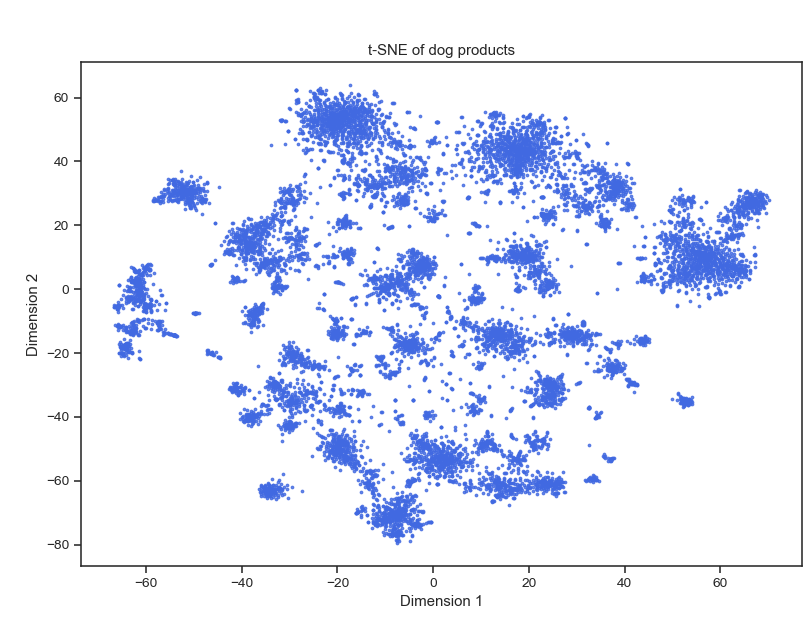

In [13]:
# Scatter plot of t-SNE
plt.figure(figsize=(9,7))
tsne_features = tsne_features_dog

plt.scatter(tsne_features[:,0], tsne_features[:,1], s=4, alpha=0.8, c='royalblue')  
plt.title('t-SNE of dog products')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.subplots_adjust(left=0.1, right=0.99, bottom=0.1, top=0.9)     
plt.show()

There seems to be less than 10 big clusters, and many small clusters. Now, let's start hierarchical clustering!

#### 4.1.3. Hierarchical clustering

First, I would like to divide the data into less than 10 categories (call them big_categories). Second, each of the big_categories will be devided into subcategories (call them small_categories).

**4.1.3.1. Big categories**

Let's plot the dendrogram and see the outline.

<IPython.core.display.Javascript object>


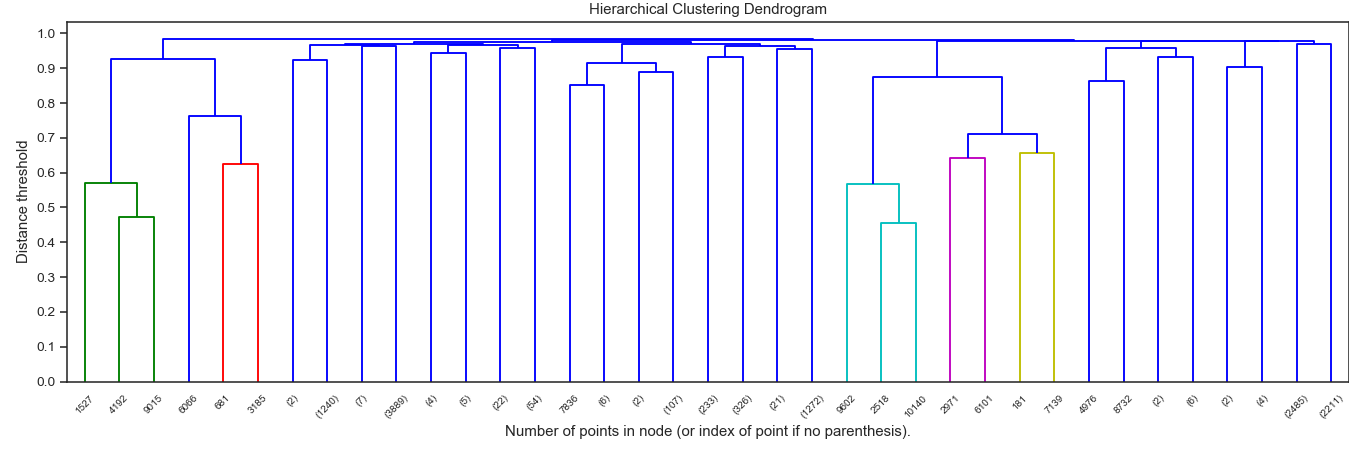

In [14]:
# Agglomeral clustering setting distance_threshold=0 to compute the full tree
model_dog = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='cosine', linkage='average')
model_dog = model_dog.fit(np_normalized_bow_dog)

# plot the top five levels of the dendrogram
plt.figure(figsize=(15,5))

plot_dendrogram(model_dog, truncate_mode='level', p=5)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Distance threshold")
plt.yticks([i/10 for i in range(0,11,1)])

plt.subplots_adjust(left=0.05, right=0.999, bottom=0.15, top=0.95)
plt.show()

According to the dendrogram, some mini clusters join up with the big clusters in the upper course of the dendrogram. That means the mini clusters are not very similar to the main clusters. We can call them "other".
I would like to divide the data into less than 10 big_categories. So, let's check the silhouette scores from k = 5 to 20.

In [15]:
# Agglomeral clustering from k = 5 to 20 
n_k_dog, scores_dog, n_samples_dog  = aggclus_silscore_nsamples(5, 20, 1, np_normalized_bow_dog)

<IPython.core.display.Javascript object>


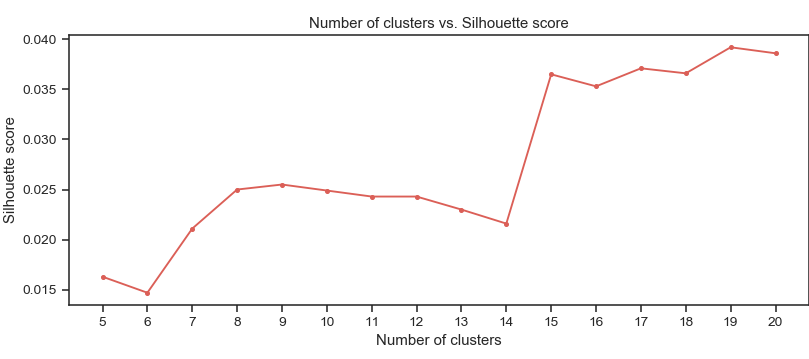

In [16]:
# Plot Number of clusters vs. Silhouette score
plt.figure(figsize=(9,4))

n_clusters = n_k_dog
sil_scores = scores_dog

plt.plot(n_clusters, sil_scores, '.-')
plt.xticks(n_clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Number of clusters vs. Silhouette score')

plt.subplots_adjust(left=0.085, right=0.999, bottom=0.15, top=0.9)
plt.show()

When k = 9, 15, 19, the scores are relatively high. Let's check the number of big clusters in each case.

In [17]:
# Count the number of products in each cluster
for k in [9, 15, 19]:
    n_cluster = k - 5
    count = 0
    for i in range(len(n_samples_dog[n_cluster])):
        if n_samples_dog[n_cluster][i] > 100:
            count += 1
    print('k =', k)
    print(n_samples_dog[n_cluster])
    print('Number of clusters more than 100 samples:', count)
    print('')

k = 9
{0: 2211, 1: 2485, 2: 5223, 3: 10, 4: 6, 5: 6, 6: 1852, 7: 7, 8: 116}
Number of clusters more than 100 samples: 5

k = 15
{0: 88, 1: 2485, 2: 2092, 3: 10, 4: 22, 5: 3896, 6: 1852, 7: 7, 8: 116, 9: 6, 10: 76, 11: 6, 12: 9, 13: 9, 14: 1242}
Number of clusters more than 100 samples: 6

k = 19
{0: 3896, 1: 22, 2: 1285, 3: 1200, 4: 76, 5: 2065, 6: 1293, 7: 10, 8: 27, 9: 6, 10: 70, 11: 6, 12: 9, 13: 9, 14: 1242, 15: 7, 16: 18, 17: 116, 18: 559}
Number of clusters more than 100 samples: 8



Although k = 9 have one huge cluster (cluster_2), K = 15 and 19 have some big clusters and many mini clusters. Let's try k = 19. We can also see k = 15 through k = 19 because the merging is continuous. 

In [18]:
# Agglomeral clustering; k = 19
model_dog_19 = AgglomerativeClustering(n_clusters=19, affinity='cosine', linkage='average')
model_dog_19 = model_dog_19.fit(np_normalized_bow_dog)

<IPython.core.display.Javascript object>


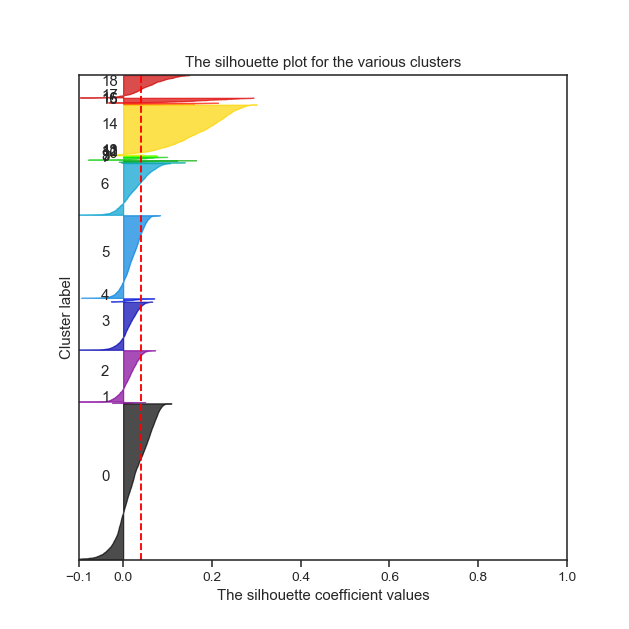

For n_clusters = 19 , The average silhouette_score is : 0.03920719437585718


In [19]:
# Silhouette plot
silhouette_plot(model_dog_19.n_clusters_, model_dog_19.labels_, np_normalized_bow_dog)

<IPython.core.display.Javascript object>


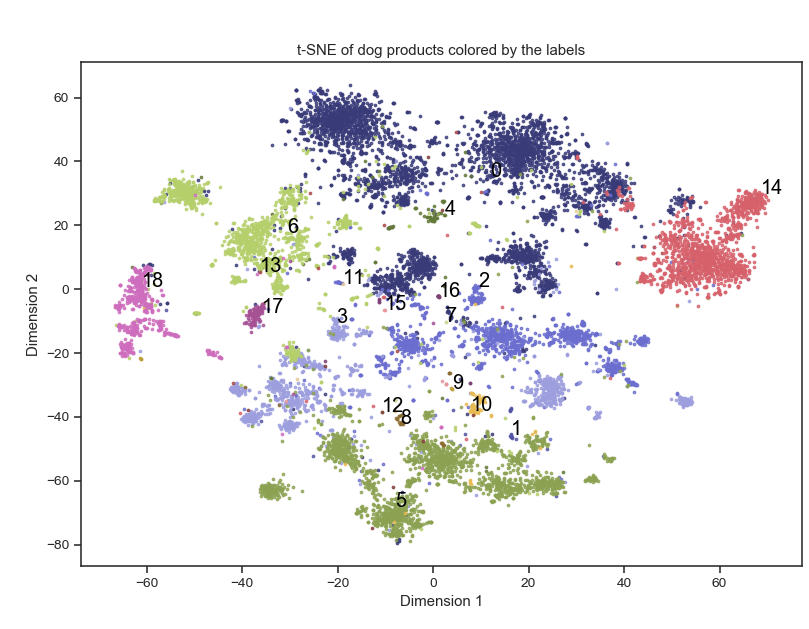

In [20]:
# t-SNE of dog products colored by the labels
plt.figure(figsize=(9,7))

model = model_dog_19
tsne_features = tsne_features_dog

for i in range(model.n_clusters_):
    plt.scatter(tsne_features[model.labels_ == i][:,0], 
                tsne_features[model.labels_ == i][:,1], 
                s=4, alpha=0.8, c=[cmap1(i/model.n_clusters_)])   
    plt.text(tsne_features[model.labels_ == i][:,0][0],
             tsne_features[model.labels_ == i][:,1][0],
             str(i), color="black", size=16)

plt.title('t-SNE of dog products colored by the labels')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.subplots_adjust(left=0.1, right=0.99, bottom=0.1, top=0.9)
plt.show()

Additionaly, let's check the frequent words in each cluster.

In [21]:
# Apply the labels to the product table
df_label_dog = df_dog_id_name[['product_id', 'product_title']]
df_label_dog['label_19'] = model_dog_19.labels_

# Count the number of products in each clusters
frequent_words(df_label_dog, 'label_19', new_dog_token_list)

,frequent words,number of products
cluster number,,
0,"(food, treat, eat, bag, mix, chew, vet, sinc, lab, pup)",3896
1,"(area, air, devic, track, home, cat, batteri, tagg, call, let)",22
2,"(bed, pad, fit, crate, wash, cat, door, cover, room, comfort)",1285
3,"(fit, mix, materi, strap, car, comfort, seat, stay, chihuahua, ador)",1200
4,"(storm, mix, thunder, calm, firework, anxieti, effect, vet, thunderstorm, rescu)",76
5,"(collar, leash, walk, fit, train, color, pull, comfort, har, neck)",2065
6,"(smell, coat, skin, bath, shampoo, hair, dri, flea, vet, spray)",1293
7,"(camera, video, watch, gift, monitor, app, night, view, fun, wifi)",10
8,"(beauti, pass, gift, photo, belov, person, urn, collar, metal, ash)",27


From the sample sizes, cluster_2 and 3 is one cluster, and cluster_6 and 18 is one cluster when k = 15. I guess cluster_6 and 18 can be one category such as 'body care, cleaning' but cluster_2 and 3 have each feature. Let's look each cluster closely. 
Take a look at the product titles in each cluster, and think whether the separation is appropriate.

In [22]:
# Check the products in each cluster
df_label_dog[df_label_dog['label_19'] == 18].sample(10)

,product_id,product_title,label_19
9356,783097700,Millers Forge Universal Pet Slicker BrushMillers Forge Universal Pet Slicker BrushMillers Forge ...,18
7867,661190026,Master Equipment Grooming Table with ArmMaster Equipment Grooming Table with ArmMaster Equipment...,18
3356,278365480,"Master Equipment Small Pet Grooming Table, PinkMaster Equipment Small Pet Grooming Table, PinkMa...",18
779,61963024,Dog Nail Clippers and Trimmer By Boshel - With Safety Guard to Avoid Over-cutting Nails & Free N...,18
3950,328197488,"#1 Best Professional Pet Nail Clipper,Easy and Safe To Use …#1 Best Professional Pet Nail Clippe...",18
11837,994122615,Best Dog Claw Trimmer - These Dog Nail Clippers Include A FREE Nail File - Keep Your Pet Safe Wi...,18
6966,584874426,"WildZu Professional Pet, Dog, and Cat Nail ClippersWildZu Professional Pet, Dog, and Cat Nail Cl...",18
10508,882893927,Cowboy Magic Conditioner 32 ozCowboy Magic Conditioner 32 ozCowboy Magic Conditioner 32 ozCowboy...,18
302,21759379,EQyss Mega-Tek Pet RebuilderEQyss Mega-Tek Pet RebuilderEQyss Mega-Tek Pet RebuilderEQyss Mega-T...,18
3448,285117007,"Millers Forge Stainless Steel Dog Nail Clipper, Plier StyleMillers Forge Stainless Steel Dog Nai...",18


According to the Silhouette plot, the t-SNE image with the labels, the frequent words, and browsing the product titles in each cluster, cluster_0, 2, 3, 5, 6, and 14 have individual features, and I evaluate they are appropriate as the big_categories respectively. Cluster_18 is similar to cluster_6. So, let's get them together. As a result, we have had 6 big_categories. The rest of clusters have fewer products. Let's think about them as 'other' group. However, some of them also have a unique character. I'll also label them. 

In [23]:
# Label each category title (from the above two tables)
big_category_labels_dog = {0:"food, treat, treatment", 1:"other", 2:"bed, crate, gate", 3:"clothes", 4:"other", 
                           5:"collar, leash", 6:"body care, cleaning", 7:"other", 8:"other", 9:"other", 10:"other", 
                           11:"other", 12:"other", 13:"other", 14:"toy", 15:"other", 16:"other", 17:"other", 
                           18:"body care, cleaning"}

# Label each category title of the 'other' group (from the above table)
other_category_labels_dog = {1:"other", 4:"calming", 7:"monitoring", 8:"memorial", 9:"other", 10:"tie out", 
                             11:"other", 12:"other", 13:"other", 15:"aquarium", 16:"other", 17:"eye care"}

I noticed several things.  Let's take care of these later.
- Cluster_15 is not for dogs, but fish.  
- Cluster_10 can be in cluster_2 ("bed, crate, gate").  
- Cluster_17 can be in cluster_6 ("body care, cleaning"). 

Now, let's extract the big 7 clusters (cluster_0, 2, 3, 5, 6, 14, 18) for farther clustering.

In [24]:
# Separate the df_label_dog into two tables; the big clusters, the 'other' group
big_clusters_dog = [0, 2, 3, 5, 6, 14, 18]
df_label_dog_big = pd.DataFrame()
df_label_dog_other = pd.DataFrame()

for i in range(len(df_label_dog)):
    if i in big_clusters_dog:
        df_label_dog_big = df_label_dog_big.append(df_label_dog[df_label_dog['label_19'] == i])
    else:
        df_label_dog_other = df_label_dog_other.append(df_label_dog[df_label_dog['label_19'] == i])

# Sort by the indexes
df_label_dog_big = df_label_dog_big.sort_index()
df_label_dog_other = df_label_dog_other.sort_index()

id-title table for the big clusters:

In [25]:
print(len(df_label_dog_big), 'products')
print('df_label_dog_big (first 5 products):')
df_label_dog_big.head()

11540 products
df_label_dog_big (first 5 products):


,product_id,product_title,label_19
0,119780,"ARK Naturals PRODUCTS for PETS 326066 4-Ounce Breath-Less Chewable Brushless Toothpaste, MiniARK...",0
1,202371,"Stella & Chewy's Freeze Dried Dog Food for Adult Dogs, Chicken Patties, 15 Ounce Bag - 2 PackSte...",0
2,291967,Premium Deshedding Brush for Dogs and Cats with Medium to Long Hair | Veterinary Approved | Rugg...,18
3,490904,"Remington Coastal Pet R0206 GRN06 Rope Leash, 72-Inch, GreenRemington Coastal Pet R0206 GRN06 Ro...",5
4,798322,Pet Dog Puppy Nonslip Canvas Sport Shoes Sneaker Boots Rubber Sole Size 5 Blue by MallofusaPet D...,3


id-title table for the other clusters:

In [26]:
print(len(df_label_dog_other), 'products')
print('df_label_dog_other (first 5 products):')
df_label_dog_other.head()

376 products
df_label_dog_other (first 5 products):


,product_id,product_title,label_19
24,2443024,"Prestige Super-Beast Dog Tie-Out, 15-FeetPrestige Super-Beast Dog Tie-Out, 15-FeetPrestige Super...",10
53,4480424,Angels Eyes Product ScoopAngels Eyes Product ScoopAngels Eyes Product ScoopAngels Eyes Product S...,17
70,5872617,Ocu-GLO Vision Supplement for Dogs by Animal Necessity - Antioxidant Vision - Protect Against Di...,17
89,6913915,"PAWCY 6100 Doggy Lazy Raft, SmallPAWCY 6100 Doggy Lazy Raft, SmallPAWCY 6100 Doggy Lazy Raft, Sm...",16
132,10339196,Beef Trachea Made in USABeef Trachea Made in USABeef Trachea Made in USABeef Trachea Made in USA...,13


Also, let's separate the bow matrix and t-SNE features of the big clusters. 

In [27]:
# Get the normalized bow matrix of the big clusters
np_normalized_bow_dog_big = np.array([np_normalized_bow_dog[i] 
                                          for i in range(len(np_normalized_bow_dog)) if i in df_label_dog_big.index])

print('Normarized BOW matrix of big_categories: np_normalized_bow_dog_big')
print('Matrix shape:', np_normalized_bow_dog_big.shape)

Normarized BOW matrix of big_categories: np_normalized_bow_dog_big
Matrix shape: (11540, 5000)


In [28]:
# Get the t-SNE features of the big clusters
tsne_features_dog_big = np.array([tsne_features_dog[i] 
                                      for i in range(len(tsne_features_dog))if i in df_label_dog_big.index])

print('T-SNE features of big_categories: tsne_features_dog_big')
print('Feature shape:', tsne_features_dog_big.shape)

T-SNE features of big_categories: tsne_features_dog_big
Feature shape: (11540, 2)


Let's move on to farther clustering for small_categories!

**4.1.3.2. Small categories**

What is the appropriate number of small_categories? If the number is large, we can find more specific features (products). However, it could be too specific. Also, I'll decide the cluster name by hand checking the product titles. Let's say less than 50. Check the silhouette scores from k = 20 to 50 roughly to get some ideas to decide the number of the small_categories.

In [29]:
# Agglomeral clustering; k = 20 to 50 
rough_n_k_dog, rough_scores_dog, _  = aggclus_silscore_nsamples(20, 50, 5, np_normalized_bow_dog_big)

<IPython.core.display.Javascript object>


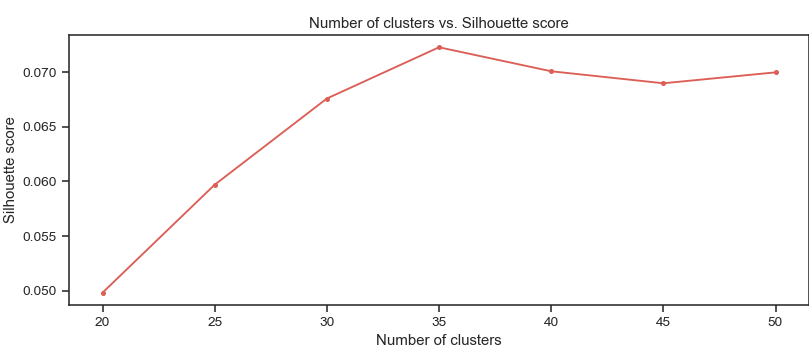

In [30]:
# Plot Number of clusters vs. Silhouette score
plt.figure(figsize=(9,4))

n_clusters = rough_n_k_dog
sil_scores = rough_scores_dog

plt.plot(n_clusters, sil_scores, '.-')
plt.xticks(n_clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Number of clusters vs. Silhouette score')

plt.subplots_adjust(left=0.085, right=0.999, bottom=0.15, top=0.9)
plt.show()

The peak is around k = 35. The number of small_categories would be around there. Let' s check from 30 to 40 finely.

In [31]:
# Agglomeral clustering; k = 30 to 40 
small_n_k_dog, small_scores_dog, _ = aggclus_silscore_nsamples(30, 40, 1, np_normalized_bow_dog_big)

<IPython.core.display.Javascript object>


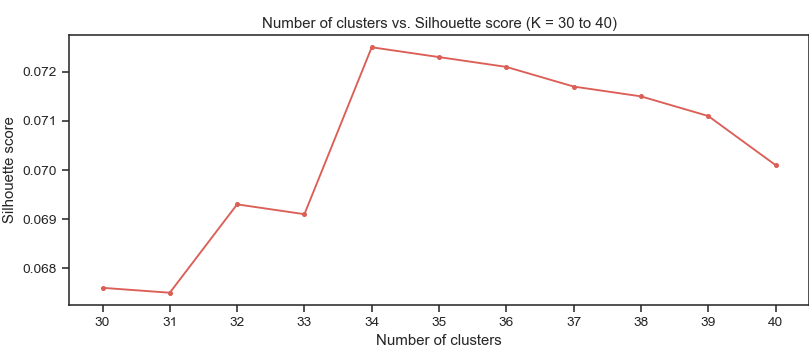

In [32]:
# Plot Number of clusters vs. Silhouette score
plt.figure(figsize=(9,4))

n_clusters = small_n_k_dog
sil_scores = small_scores_dog

plt.plot(n_clusters, sil_scores, '.-')
plt.xticks(n_clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Number of clusters vs. Silhouette score (K = 30 to 40)')

plt.subplots_adjust(left=0.085, right=0.999, bottom=0.15, top=0.9)
plt.show()

When k = 34, the Sihouette score is highest. Let's decide k = 34 for the small_categories. Do clustering on k = 34, and get the labels.

In [33]:
# Agglomerative clustering (n_clusters=34, small_categories)
n_clusters=34

model_dog_34 = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='average')
model_dog_34 = model_dog_34.fit(np_normalized_bow_dog_big)

<IPython.core.display.Javascript object>


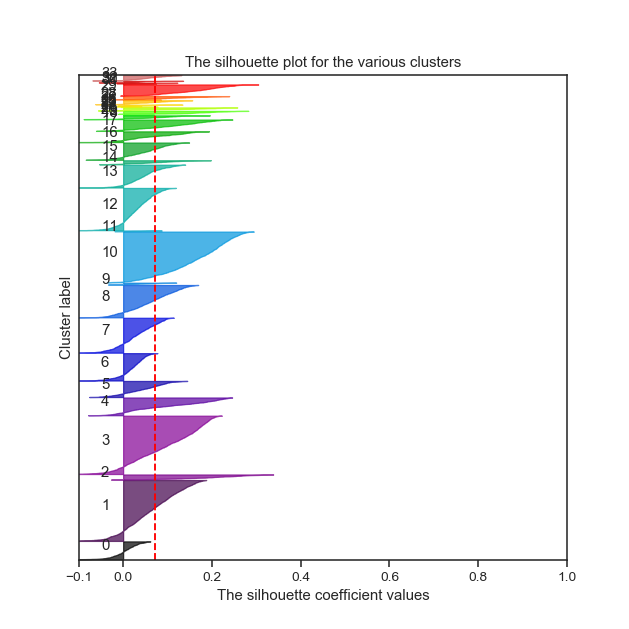

For n_clusters = 34 , The average silhouette_score is : 0.07248798338303429


In [34]:
# Plot silhouette scores
silhouette_plot(model_dog_34.n_clusters_, model_dog_34.labels_, np_normalized_bow_dog_big)

<IPython.core.display.Javascript object>


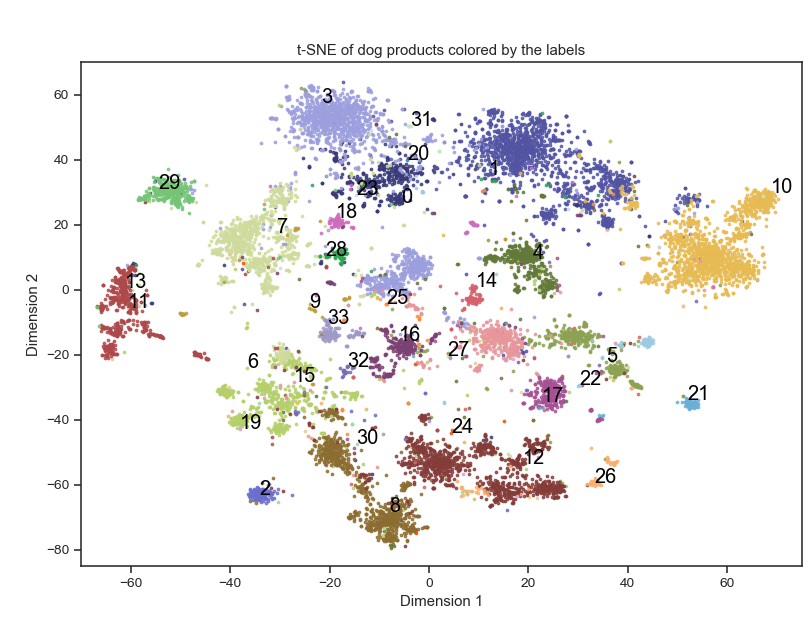

In [35]:
# Scatter plot, colored by the labels 
plt.figure(figsize=(9,7))

model = model_dog_34
tsne_features = tsne_features_dog_big

for i in range(model.n_clusters_):
# for i in [0,1,31,3,4,28,23,20]:  # Cluster_0
# for i in [25,22,15,14,16,5]:  # Cluster_2
# for i in [33,32,17,21,27,6]:  # Cluster_3
# for i in [2,30,19,8,12,26]:  # Cluster_5
# for i in [29,7,9,18,11,24,13]:  # Cluster_6
# for i in [10]:  # Cluster_14
    plt.scatter(tsne_features[model.labels_ == i][:,0], 
                tsne_features[model.labels_ == i][:,1], 
                s=4, alpha=0.8, c=[cmaps[i]])   
    plt.text(tsne_features[model.labels_ == i][:,0][0],
             tsne_features[model.labels_ == i][:,1][0],
             str(i), color="black", size=16)

plt.title('t-SNE of dog products colored by the labels')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.xlim(-70, 75)
plt.ylim(-85, 70)

plt.subplots_adjust(left=0.1, right=0.99, bottom=0.1, top=0.9)
plt.show()

In [36]:
# Add the labels on the product table
df_label_dog_big['label_34'] = model_dog_34.labels_

In [37]:
# Get the frequent words and count the number of products in each cluster
n_clusters = df_label_dog_big['label_34'].nunique()
df_34cluster_dog = pd.DataFrame(columns=['big_category_number', 'small_category_number',
                                         'frequent words', 'number of products'])

for i in range(n_clusters):
    words = []
    indexes = df_label_dog_big[df_label_dog_big['label_34'] == i].index
    big_category_number = df_label_dog_big[df_label_dog_big['label_34'] == i].iat[0, 2]
    for index in indexes:
        for word in set(new_dog_token_list[index]):
            words.append(word)
    c = Counter(words)
    values, _ = zip(*c.most_common(10))

    df_temp = pd.DataFrame([[big_category_number, i, values, len(indexes)]], 
                                columns=df_34cluster_dog.columns)
    df_34cluster_dog = df_34cluster_dog.append(df_temp) 

df_34cluster_dog.set_index(['big_category_number']).sort_index()

,small_category_number,frequent words,number of products
big_category_number,,,
0,0,"(vet, pill, eat, lab, supplement, food, hip, treat, sinc, pain)",440
0,1,"(treat, eat, chew, bone, bag, food, smell, pup, mix, flavor)",1494
0,31,"(rat, eat, hamster, rodent, sinc, hand, box, smell, mice, gerbil)",10
0,3,"(food, eat, bowl, water, mix, feed, dri, cat, bag, sinc)",1431
0,4,"(bag, poop, carri, fit, pick, hand, plastic, comfort, carrier, walk)",436
0,28,"(breath, vet, smell, treat, water, brush, cat, improv, effect, tartar)",78
0,23,"(date, expir, smell, tast, chew, market, vet, msm, sign, pay)",6
0,20,"(joint, arthriti, sit, continu, limp, compress, till, dosag, hop, tast)",1
2,25,"(cool, heat, ice, water, summer, pup, walk, stay, pack, fit)",26


Let's take a look at the product titles in each cluster, and check this separation is appropriate.

In [38]:
# Check the product titles in each cluster
df_label_dog_big[df_label_dog_big['label_34'] == 13].sample(10)

,product_id,product_title,label_19,label_34
9499,796011632,Le Salon Essentials Face Trimming Scissors for DogsLe Salon Essentials Face Trimming Scissors fo...,18,13
4360,361508452,Bio-Groom Ear Fresh Ear PowderBio-Groom Ear Fresh Ear PowderBio-Groom Ear Fresh Ear PowderBio-Gr...,18,13
4099,340331724,Le Salon Essentials Rubber Curry Grooming Brush with Loop HandleLe Salon Essentials Rubber Curry...,18,13
7792,654227570,Alfheim Professional 7-Inch Pet Hair Grooming Scissors - 36 Tooth Thinning Shear & Straight-Edge...,18,13
3929,326238360,Conair Dog Massaging Shampoo BrushConair Dog Massaging Shampoo BrushConair Dog Massaging Shampoo...,18,13
10129,849261117,"Andis ProClip AGC2 2-Speed Detachable Blade Clipper, Professional Animal Grooming, AGC, Black (2...",18,13
7472,627359579,CET Dual End ToothbrushCET Dual End ToothbrushCET Dual End ToothbrushCET Dual End ToothbrushCET ...,18,13
4514,374875047,Best Dog Nail Clippers with Quick Sensor - Easy to Use Dog Nail Trimmer and Toenail Clippers - S...,18,13
2371,191906626,"SHAPLEY'S MTG8OXDS\TSMTG DS Original M-T-G Mane Tail & Groom for Horses, 8 ozSHAPLEY'S MTG8OXDS\...",18,13
3611,297237213,"Shed Ninja Dog and Cat Brush – Grooming Tool for Short, Medium and Long Hair – Small and Large A...",18,13


The big clusters mostly have each feature. The clustering has worked well. Let's label each cluster name. 

In [39]:
# Label each category title (from the above two tables)
small_category_labels_dog = {0:"treatment, supplement", 1:"treat", 31:"other", 3:"food, bowl", 4:"waste bag, carrier",
                             28:"oral care", 23:"treatment, supplement", 20:"treatment, supplement", 
                             25:"other", 22:"door, gate, crate", 15:"bed", 14:"step", 16:"training pad", 
                             5:"door, gate, crate",
                             33:"shoes", 32:"other", 17:"car seat, cover", 21:"stroller", 27:"door, gate, crate", 
                             6:"costume", 
                             2:"ID tag", 30:"leash, harness", 19:"collar", 8:"leash, harness", 12:"collar", 26:"training",
                             29:"flea", 7:"odor, stain, shampoo", 9:"dryer, towel", 18:"ear cleaner",
                             11:"other", 24:"other", 
                             10:"toy", 
                             13:"brush, clipper"}

I noticed several things. Let's take care of these later.  
- Small_cluster_4 is in big_category_0, but should have been big_category_1 ("other").  
- Small_cluster_16 is in big_category_2, but should have been big_category_1 ("other").  
- Small_cluster_17 and 21 are in big_category_3, but should have been big_category_1 ("other").  
- Small_cluster_27 is in big_category_3, but should have been big_category_2.  
- Small_cluster_26 is in big_category_5, but should have been big_category_1 ("other").  
- Small_cluster_11 and 24 are in big_category_6, but should have been big_category_1 ("other").  

**4.1.3.3. Make the summary tables**

Now, each of the dog products has a big_category label and a small_category label. In this section, let's make the summary table that has rows representing each product with the id, title, and each category label.  

In [40]:
# Make a new datafeame from df_label_dog_big for summary
df_label_dog_summary = df_label_dog_big[['product_id', 'product_title', 'label_19', 'label_34']]

# Add 'animal' column
df_label_dog_summary['animal'] = 'dog'

print('df_label_dog_summary (first 5 rows):')
df_label_dog_summary.head()

df_label_dog_summary (first 5 rows):


,product_id,product_title,label_19,label_34,animal
0,119780,"ARK Naturals PRODUCTS for PETS 326066 4-Ounce Breath-Less Chewable Brushless Toothpaste, MiniARK...",0,1,dog
1,202371,"Stella & Chewy's Freeze Dried Dog Food for Adult Dogs, Chicken Patties, 15 Ounce Bag - 2 PackSte...",0,3,dog
2,291967,Premium Deshedding Brush for Dogs and Cats with Medium to Long Hair | Veterinary Approved | Rugg...,18,13,dog
3,490904,"Remington Coastal Pet R0206 GRN06 Rope Leash, 72-Inch, GreenRemington Coastal Pet R0206 GRN06 Ro...",5,8,dog
4,798322,Pet Dog Puppy Nonslip Canvas Sport Shoes Sneaker Boots Rubber Sole Size 5 Blue by MallofusaPet D...,3,33,dog


Here, take care of the mis-categorized products. Then, replace the category numbers into the names.  

In [41]:
# Take care of mis-categorized products
for i in range(len(df_label_dog_summary)):
    # Column_3 is 'label_34'
    if df_label_dog_summary.iloc[i, 3] in [4, 16, 17, 21, 26, 11, 24]:
        # Column_2 is 'label_19'
        df_label_dog_summary.iloc[i, 2] = 1
        
    elif df_label_dog_summary.iloc[i, 3] == 27:
        df_label_dog_summary.iloc[i, 2] = 2
        
# Replace the category numbers into the names
df_label_dog_summary = df_label_dog_summary.replace({'label_19': big_category_labels_dog,
                                             'label_34': small_category_labels_dog})
# Rename the columns
df_label_dog_summary = df_label_dog_summary.rename(columns={'label_19': 'big_category', 'label_34': 'small_category'})

print('df_label_dog_summary (first 5 rows):')
df_label_dog_summary.head()

df_label_dog_summary (first 5 rows):


,product_id,product_title,big_category,small_category,animal
0,119780,"ARK Naturals PRODUCTS for PETS 326066 4-Ounce Breath-Less Chewable Brushless Toothpaste, MiniARK...","food, treat, treatment",treat,dog
1,202371,"Stella & Chewy's Freeze Dried Dog Food for Adult Dogs, Chicken Patties, 15 Ounce Bag - 2 PackSte...","food, treat, treatment","food, bowl",dog
2,291967,Premium Deshedding Brush for Dogs and Cats with Medium to Long Hair | Veterinary Approved | Rugg...,"body care, cleaning","brush, clipper",dog
3,490904,"Remington Coastal Pet R0206 GRN06 Rope Leash, 72-Inch, GreenRemington Coastal Pet R0206 GRN06 Ro...","collar, leash","leash, harness",dog
4,798322,Pet Dog Puppy Nonslip Canvas Sport Shoes Sneaker Boots Rubber Sole Size 5 Blue by MallofusaPet D...,clothes,shoes,dog


I would like to merge the 'other' group and df_label_dog_summary. Frist, let's make df_label_dog_other having the same columns as df_label_dog_summary, and take care of the mis-categorized products. Remember them:

- Cluster_15 is not for dogs, but fish.  
- Cluster_10 can be in cluster_2 ("bed, crate, gate").  
- Cluster_17 can be in cluster_6 ("body care, cleaning").  

In [42]:
# Make a new datafeame from df_label_dog_other for summary
df_other_dog = df_label_dog_other[['product_id', 'product_title', 'label_19']]

# Add 'big_category' column
df_other_dog['big_category'] = 'other'

# Add 'animal' column
df_other_dog['animal'] = 'dog'

# Take care of mis-categorized products 
for i in range(len(df_other_dog)):
    # Column_2 is 'label_19'
    if df_other_dog.iloc[i, 2] == 15:
        # Column_3 is 'big_categories'
        df_other_dog.iloc[i, 3] = 'fish, reptile'
        # Column_4 is 'animal'
        df_other_dog.iloc[i, 4] = 'other'
    
    elif df_other_dog.iloc[i, 2] == 10:
        df_other_dog.iloc[i, 3] = 'bed, crate, gate'
    
    elif df_other_dog.iloc[i, 2] == 17:
        df_other_dog.iloc[i, 3] = 'body care, cleaning'

# Replace the category numbers with the names
df_other_dog = df_other_dog.replace({'label_19': other_category_labels_dog})

# Rename the column
df_other_dog = df_other_dog.rename(columns={'label_19': 'small_category'})

print('df_other_dog (first 5 rows):')
df_other_dog.head()

df_other_dog (first 5 rows):


,product_id,product_title,small_category,big_category,animal
24,2443024,"Prestige Super-Beast Dog Tie-Out, 15-FeetPrestige Super-Beast Dog Tie-Out, 15-FeetPrestige Super...",tie out,"bed, crate, gate",dog
53,4480424,Angels Eyes Product ScoopAngels Eyes Product ScoopAngels Eyes Product ScoopAngels Eyes Product S...,eye care,"body care, cleaning",dog
70,5872617,Ocu-GLO Vision Supplement for Dogs by Animal Necessity - Antioxidant Vision - Protect Against Di...,eye care,"body care, cleaning",dog
89,6913915,"PAWCY 6100 Doggy Lazy Raft, SmallPAWCY 6100 Doggy Lazy Raft, SmallPAWCY 6100 Doggy Lazy Raft, Sm...",other,other,dog
132,10339196,Beef Trachea Made in USABeef Trachea Made in USABeef Trachea Made in USABeef Trachea Made in USA...,other,other,dog


Merge the two tables in one.

In [43]:
# Merge df_label_dog_summary and df_other_dog
df_label_dog_summary = df_label_dog_summary.append(df_other_dog)

print('df_label_dog_summary (first 5 rows):')
df_label_dog_summary.head()

df_label_dog_summary (first 5 rows):


,product_id,product_title,big_category,small_category,animal
0,119780,"ARK Naturals PRODUCTS for PETS 326066 4-Ounce Breath-Less Chewable Brushless Toothpaste, MiniARK...","food, treat, treatment",treat,dog
1,202371,"Stella & Chewy's Freeze Dried Dog Food for Adult Dogs, Chicken Patties, 15 Ounce Bag - 2 PackSte...","food, treat, treatment","food, bowl",dog
2,291967,Premium Deshedding Brush for Dogs and Cats with Medium to Long Hair | Veterinary Approved | Rugg...,"body care, cleaning","brush, clipper",dog
3,490904,"Remington Coastal Pet R0206 GRN06 Rope Leash, 72-Inch, GreenRemington Coastal Pet R0206 GRN06 Ro...","collar, leash","leash, harness",dog
4,798322,Pet Dog Puppy Nonslip Canvas Sport Shoes Sneaker Boots Rubber Sole Size 5 Blue by MallofusaPet D...,clothes,shoes,dog


This df_label_dog_summary shows the category label of each product for dogs. That's all for dog products!

### 4.2. Cat category

Let's do clustering of Cat category in the same way as Dog category.

#### 4.2.1. Load data

Token list:

In [44]:
# Load the token list
cat_token_list = []
with open("cat_token_list.csv", "r", encoding="UTF-8") as f:
    reader = csv.reader(f) 
    for r in reader: 
        cat_token_list.append(r)

print('cat_token_list (first 5 tokens of the first product):', cat_token_list[0][:5])
print('Number of products:', len(cat_token_list))
print('Number of unique tokens:', len(set(token for review in cat_token_list for token in review)))

cat_token_list (first 5 tokens of the first product): ['templat', 'wont', 'door', 'pick', 'litter']
Number of products: 4099
Number of unique tokens: 6001


Remove cat related tokens.

In [45]:
# Remove cat tokens 
cat_tokens = ['cat', 'kitti', 'kitten']
new_cat_token_list = []

for product in cat_token_list:
    nested_list = []
    for token in product:
        if token not in cat_tokens:
            nested_list.append(token)
    new_cat_token_list.append(nested_list)

print('new_cat_token_list (first 5 tokens of the first product):', new_cat_token_list[0][:5])
print('Number of products:', len(new_cat_token_list))
print('Number of unique tokens:', len(set(token for review in new_cat_token_list for token in review)))

new_cat_token_list (first 5 tokens of the first product): ['templat', 'wont', 'door', 'pick', 'litter']
Number of products: 4099
Number of unique tokens: 5998


ID-title table:

In [46]:
# Load the product table
df_cat_id_name = pd.read_csv("df_cat_id_name.csv")

print('df_cat_id_name (first 5 products):')
df_cat_id_name.head()

df_cat_id_name (first 5 products):


,product_id,product_title
0,70064,Perfect Pet Soft Flap Cat Door with Telescoping FramePerfect Pet Soft Flap Cat Door with Telesco...
1,593896,Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set o...
2,919291,Basis Pet Made in the USA Low Profile Stainless Steel Cat DishBasis Pet Made in the USA Low Prof...
3,944764,Alfie Pet by Petoga Couture - Vea 2.0 Slow-Eating Anti-Gulping Pet Food Bowl (for Dogs & Cats)Al...
4,1124833,Petmate Hooded Cat Litter PanPetmate Hooded Cat Litter PanPetmate Hooded Cat Litter PanPetmate H...


#### 4.2.2. Vectorization

New_cat_token_list has 5,998 kinds of tokens. Additionaly, I use bigrams as the dog dataset. To control the number of tokens, tokens appearing less than 6 times in the total documents are cut.

In [47]:
# Create CountVectorizer object 
cvectorizer_cat = CountVectorizer(tokenizer=dummy_tokened,lowercase=False, min_df=6, ngram_range=(1, 2))
bow_cat = cvectorizer_cat.fit_transform(new_cat_token_list)

# Get the feature names
feature_names_cat = cvectorizer_cat.get_feature_names()

# Show the shape of bow_matrix
print('BOW matrix: bow_cat')
print('Matrix shape:', bow_cat.shape)

BOW matrix: bow_cat
Matrix shape: (4099, 4665)


In [48]:
# Normarize the bow matrix
normalized_bow_cat = normalize(bow_cat)

# Change the normalizer bow matrix into np.array to use for AgglomerativeClustering()
np_normalized_bow_cat = normalized_bow_cat.toarray()

print('Normarized BOW matrix: np_normalized_bow_cat')
print('Matrix shape:', np_normalized_bow_cat.shape)

Normarized BOW matrix: np_normalized_bow_cat
Matrix shape: (4099, 4665)


In [49]:
# Create a t-SNE instance
tsne_cat = TSNE(perplexity=50, learning_rate=800, random_state=10)

# Apply fit_transform to samples
tsne_features_cat = tsne_cat.fit_transform(normalized_bow_cat)

<IPython.core.display.Javascript object>


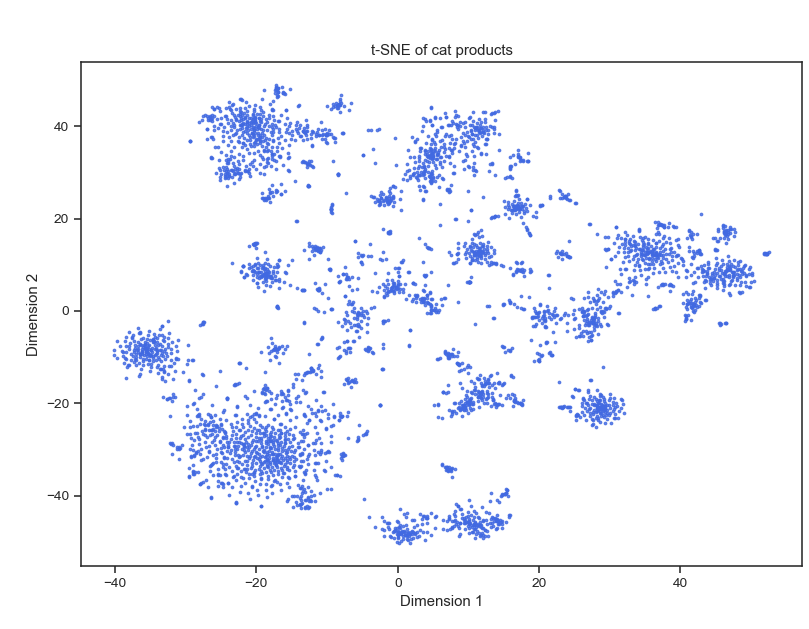

In [50]:
# Scatter plot of t-SNE
plt.figure(figsize=(9,7))
tsne_features = tsne_features_cat

plt.scatter(tsne_features[:,0], tsne_features[:,1], s=4, alpha=0.8, c='royalblue')   

plt.title('t-SNE of cat products')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.subplots_adjust(left=0.1, right=0.99, bottom=0.1, top=0.9)
plt.show()

There seems to be less than 8 big clusters, and some small clusters. Now, let's start hierarchical clustering!

#### 4.2.3. Hierarchical clustering

First, I would like to divide the data into less than 8 categories. Second, each of the big_categories will be devided into subcategories.

**4.1.3.1. Big categories**

In [51]:
# Agglomeral clustering setting distance_threshold=0 to compute the full tree
model_cat = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='cosine', linkage='average')
model_cat = model_cat.fit(np_normalized_bow_cat)

<IPython.core.display.Javascript object>


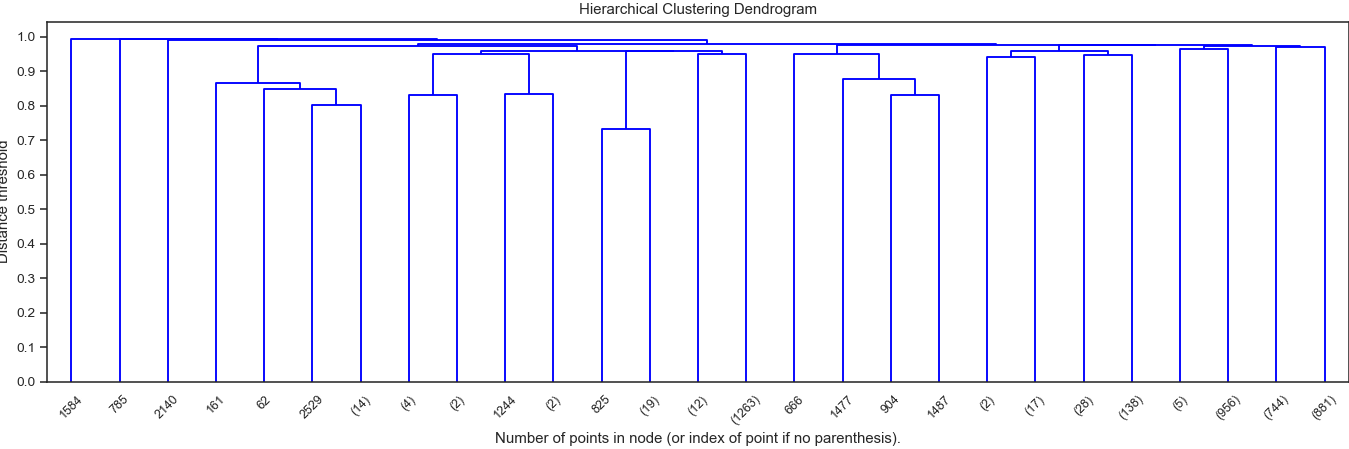

In [52]:
# plot the top seven levels of the dendrogram
plt.figure(figsize=(15,5))

plot_dendrogram(model_cat, truncate_mode='level', p=7)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Distance threshold")
plt.yticks([i/10 for i in range(0,11,1)])

plt.subplots_adjust(left=0.035, right=0.999, bottom=0.15, top=0.95)
plt.show()

According to the dendrogram above, some mini clusters join up with the big clusters in the upper course of the dendrogram. Let's collect them as the "other" group.  
I would like to divide the data into less than 8 big_categories. So, let's check the silhouette scores from k = 5 to 15.

In [53]:
# Agglomeral clustering from k = 5 to 15
n_k_cat, scores_cat, n_samples_cat  = aggclus_silscore_nsamples(5, 15, 1, np_normalized_bow_cat)

<IPython.core.display.Javascript object>


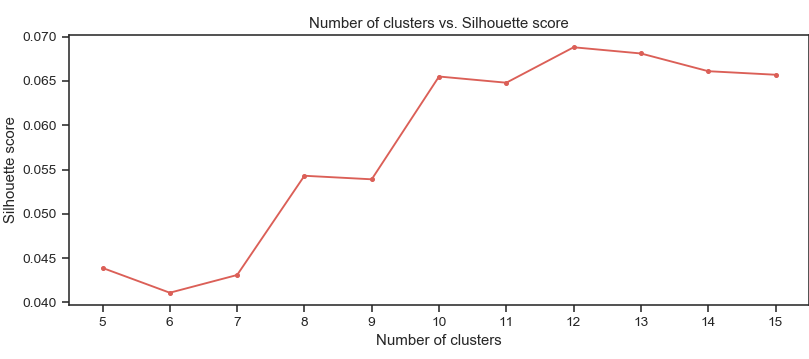

In [54]:
# Plot Number of clusters vs. Silhouette score
plt.figure(figsize=(9,4))

n_clusters = n_k_cat
sil_scores = scores_cat

plt.plot(n_clusters, sil_scores, '.-')

plt.xticks(n_clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Number of clusters vs. Silhouette score')

plt.subplots_adjust(left=0.085, right=0.999, bottom=0.15, top=0.9)
plt.show()

When k = 10 and 12, the scores are relatively high. Let's check the number of big clusters in each case.

In [55]:
# Count the number of samples in each cluster
for k in [10, 12]:
    n_cluster = k - 5
    count = 0
    for i in range(len(n_samples_cat[n_cluster])):
        if n_samples_cat[n_cluster][i] > 100:
            count += 1
    print('k =', k)
    print(n_samples_cat[n_cluster])
    print('Number of clusters more than 100 samples:', count)
    print('')

k = 10
{0: 961, 1: 881, 2: 185, 3: 1304, 4: 744, 5: 1, 6: 4, 7: 1, 8: 17, 9: 1}
Number of clusters more than 100 samples: 5

k = 12
{0: 518, 1: 956, 2: 185, 3: 1304, 4: 744, 5: 363, 6: 4, 7: 1, 8: 17, 9: 1, 10: 5, 11: 1}
Number of clusters more than 100 samples: 6



When k = 10, cluster_0 and 5 of k = 12 are one cluster; cluster_1. Let's try k = 12, and see whether the two clusters should be separated.

In [56]:
# Agglomeral clustering; k = 12 
model_cat_12 = AgglomerativeClustering(n_clusters=12, affinity='cosine', linkage='average')
model_cat_12 = model_cat_12.fit(np_normalized_bow_cat)

<IPython.core.display.Javascript object>


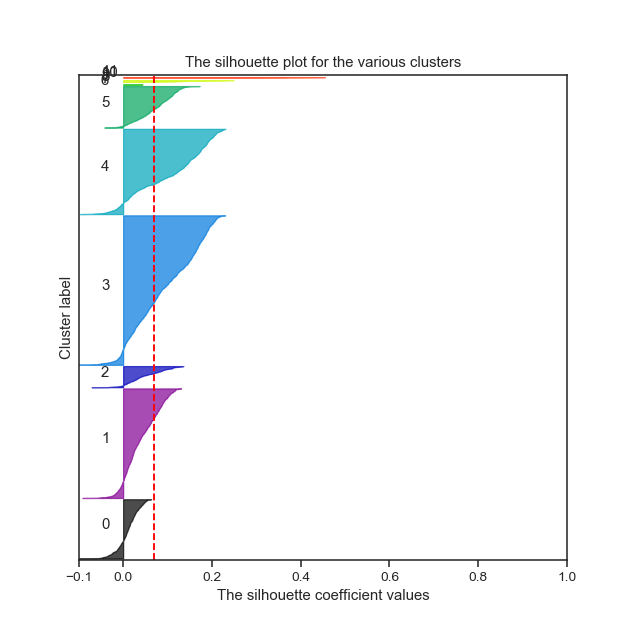

For n_clusters = 12 , The average silhouette_score is : 0.06875282567482995


In [57]:
# Silhouette plot
silhouette_plot(model_cat_12.n_clusters_, model_cat_12.labels_, np_normalized_bow_cat)

<IPython.core.display.Javascript object>


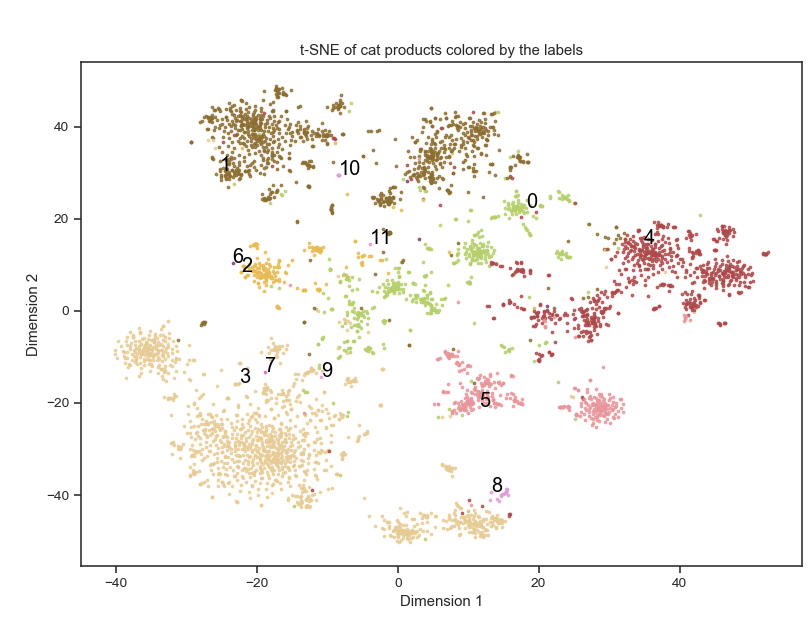

In [58]:
# t-SNE of cat products colored by the labels
plt.figure(figsize=(9,7))

model = model_cat_12
tsne_features = tsne_features_cat

for i in range(model.n_clusters_):
    plt.scatter(tsne_features[model.labels_ == i][:,0], 
                tsne_features[model.labels_ == i][:,1], 
                    s=4, alpha=0.8, c=[cmap1((i+4)/model.n_clusters_)]) 
    plt.text(tsne_features[model.labels_ == i][:,0][0],
             tsne_features[model.labels_ == i][:,1][0],
             str(i), color="black", size=16)
        
plt.title('t-SNE of cat products colored by the labels')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.subplots_adjust(left=0.1, right=0.99, bottom=0.1, top=0.9)
plt.show()

In [59]:
# Apply the labels to the product table
df_label_cat = df_cat_id_name[['product_id', 'product_title']]
df_label_cat['label_12'] = model_cat_12.labels_

# Count the number of products in each clusters
frequent_words(df_label_cat, 'label_12', new_cat_token_list)

,frequent words,number of products
cluster number,,
0,"(dog, fit, door, side, room, comfort, insid, bed, carrier, vet)",518
1,"(play, toy, scratch, box, sturdi, post, fun, catnip, room, jump)",956
2,"(collar, color, fit, bell, neck, dog, design, stay, comfort, tag)",185
3,"(food, eat, dri, dog, feed, treat, water, flavor, vet, bowl)",1304
4,"(litter, box, smell, odor, scoop, clump, bag, floor, spray, room)",744
5,"(dog, hair, flea, brush, fur, groom, remov, comb, effect, coat)",363
6,"(chair, dog, sound, tool, train, spray, furnitur, clunki, respond, wrist)",4
7,"(ask, pleas, letter, spend, manufactur, jus, vitamin, wife, import, sell)",1
8,"(tank, aquarium, gallon, water, color, quit, plant, glass, con, home)",17


According to the tokens of cluster_2 and 5, they have a different feature each other. Also, the other 4 big clusters have unique features respectively. I think k = 12 is appropriate. Let's look each cluster closely, and make sure that.

In [60]:
# Check the products in each cluster
df_label_cat[df_label_cat['label_12'] == 1].sample(10)

,product_id,product_title,label_12
2371,580935922,Petmate Light Chaser Cat ToyPetmate Light Chaser Cat ToyPetmate Light Chaser Cat ToyPetmate Ligh...,1
589,147957777,BestPet 2014 Cat Tree Condo Furniture Scratch Post Pet House 80-InchBestPet 2014 Cat Tree Condo ...,1
180,43679852,Go Cat Da Bird Kitty Puff AccessoryGo Cat Da Bird Kitty Puff AccessoryGo Cat Da Bird Kitty Puff ...,1
2523,625153245,SmartyKat Block Party Cat Toy Kitten Rattle Balls 3 PackSmartyKat Block Party Cat Toy Kitten Rat...,1
1762,423070859,Go Pet Club Cat Tree Furniture 72 in. High LoftGo Pet Club Cat Tree Furniture 72 in. High LoftGo...,1
2303,561606490,From The Field FFT114 Freddy's Feather Wand Interactive Cat ToyFrom The Field FFT114 Freddy's Fe...,1
3485,855507101,The Original Scratch Lounge - Worlds Best Cat Scratcher - Includes CatnipThe Original Scratch Lo...,1
2383,584902542,Outdoor Feline FunhouseOutdoor Feline FunhouseOutdoor Feline FunhouseOutdoor Feline FunhouseOutd...,1
612,155320036,TWICE AS MICE Bright Fur Mice 12pk by Think!CatTWICE AS MICE Bright Fur Mice 12pk by Think!CatTW...,1
1276,312503084,Kitty Caps Nails Size:Medium Color:Pink/PurpleKitty Caps Nails Size:Medium Color:Pink/PurpleKitt...,1


According to the Silhouette plot, the t-SNE image with the labels, the frequent words, and browsing the product titles in each cluster, cluster_0 to 5 have individual features, and I have evaluated they are appropriate as the big_categories respectively. As a result, we have had 6 big_categories. The rest of clusters have a few products. Let's think about them as 'other' group. However, some of them also have a unique character. I'll also label them.

In [61]:
# Label each category title (from the above two tables)
big_category_labels_cat = {0:"door, cage, carrier, bed", 1:"toy, scratcher, cat tree", 2:"collar, leash",
                           3:"food, treatment", 4:"litter, odor, stain", 5:"grooming", 6:"other", 7:"other", 8:"other",
                           9:"other", 10:"other", 11:"other"}

# Label each category title of the 'other' group (from the above table)
other_category_labels_cat = {6:'other', 7:'other', 8:'aquarium', 9:'other', 10:'toy', 11:'other'}

I noticed several things.  Let's take care of these later.  
- Cluster_8 is not for cats, but fish.  
- Cluster_10 is a kind of toy (catnip bubbles).

Now, let's extract the big 6 clusters (cluster_0 to 5) for farther clustering.

In [62]:
# Divide the product table into two: the big clusters, the other group
big_clusters_cat = [0, 1, 2, 3, 4, 5]
df_label_cat_big = pd.DataFrame()
df_label_cat_other = pd.DataFrame()

for i in range(len(df_label_cat)):
    if i in big_clusters_cat:
        df_label_cat_big = df_label_cat_big.append(df_label_cat[df_label_cat['label_12'] == i])
    else:
        df_label_cat_other = df_label_cat_other.append(df_label_cat[df_label_cat['label_12'] == i])

# Sort by the indexes
df_label_cat_big = df_label_cat_big.sort_index()
df_label_cat_other = df_label_cat_other.sort_index()

id-title table for the big clusters:

In [63]:
print(len(df_label_cat_big), 'products')
print('df_label_cat_big (first 5 products):')
df_label_cat_big.head()

4070 products
df_label_cat_big (first 5 products):


,product_id,product_title,label_12
0,70064,Perfect Pet Soft Flap Cat Door with Telescoping FramePerfect Pet Soft Flap Cat Door with Telesco...,0
1,593896,Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set o...,3
2,919291,Basis Pet Made in the USA Low Profile Stainless Steel Cat DishBasis Pet Made in the USA Low Prof...,3
3,944764,Alfie Pet by Petoga Couture - Vea 2.0 Slow-Eating Anti-Gulping Pet Food Bowl (for Dogs & Cats)Al...,3
4,1124833,Petmate Hooded Cat Litter PanPetmate Hooded Cat Litter PanPetmate Hooded Cat Litter PanPetmate H...,4


id-title table for the other clusters:

In [64]:
print(len(df_label_cat_other), 'products')
print('df_label_cat_other (first 5 products):')
df_label_cat_other.head()

29 products
df_label_cat_other (first 5 products):


,product_id,product_title,label_12
62,12304637,"Wall Mounted Fish Bowl Bubble for Goldfish & Beta or Hanging Terrarium with Exclusive ""Lets Get ...",8
73,14334855,"Cholla Wood, 3 Nice Pieces of Aquarium Driftwood Decoration by Aquatic ArtsCholla Wood, 3 Nice P...",8
161,35498715,Lightahead Artificial Mini Aquarium Fish Tank Multi Color LED Swimming Fish Tank with BubblesLig...,8
224,53604498,"OurPets Bouncy North-American Catnip Bubbles, 8-OunceOurPets Bouncy North-American Catnip Bubble...",10
468,121923547,"Kookamunga Krazee Kitty Catnip Bubbles, 5 ozKookamunga Krazee Kitty Catnip Bubbles, 5 ozKookamun...",10


Also, let's separate the bow matrix and t-SNE features of the big clusters.

In [65]:
# Get the normalized bow matrix of the big clusters
np_normalized_bow_cat_big = np.array([np_normalized_bow_cat[i] 
                                          for i in range(len(np_normalized_bow_cat)) if i in df_label_cat_big.index])

print('Normarized BOW matrix of big_categories: np_normalized_bow_cat_big')
print('Matrix shape:', np_normalized_bow_cat_big.shape)

Normarized BOW matrix of big_categories: np_normalized_bow_cat_big
Matrix shape: (4070, 4665)


In [66]:
# Get the t-SNE features of the big clusters
tsne_features_cat_big = np.array([tsne_features_cat[i] 
                                      for i in range(len(tsne_features_cat))if i in df_label_cat_big.index])

print('T-SNE features of big_categories: tsne_features_cat_big')
print('Feature shape:', tsne_features_cat_big.shape)

T-SNE features of big_categories: tsne_features_cat_big
Feature shape: (4070, 2)


**4.1.3.2. Small categories**

Check the silhouette scores from k = 15 to 50 roughly to get some ideas to decide the number of the small_categories.

In [67]:
# Agglomeral clustering; k = 15 to 50 
rough_n_k_cat, rough_scores_cat, _ = aggclus_silscore_nsamples(15, 50, 5, np_normalized_bow_cat_big)

<IPython.core.display.Javascript object>


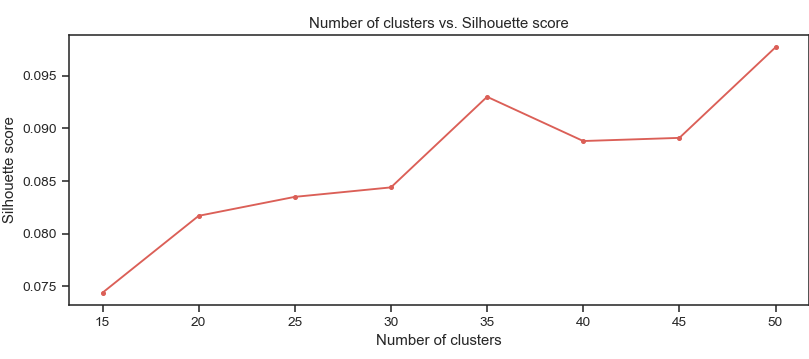

In [68]:
# Plot Number of clusters vs. Silhouette score
plt.figure(figsize=(9,4))

n_clusters = rough_n_k_cat
sil_scores = rough_scores_cat

plt.plot(n_clusters, sil_scores, '.-')
plt.xticks(n_clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Number of clusters vs. Silhouette score')

plt.subplots_adjust(left=0.085, right=0.999, bottom=0.15, top=0.9)
plt.show()

One peak is around k = 35.  Let's check the scores finely from k = 30 to 40 to choose k for the small_categories. 

In [69]:
# Decide the number of small_categories
small_n_k_cat, small_scores_cat, _ = aggclus_silscore_nsamples(30, 40, 1, np_normalized_bow_cat_big)

<IPython.core.display.Javascript object>


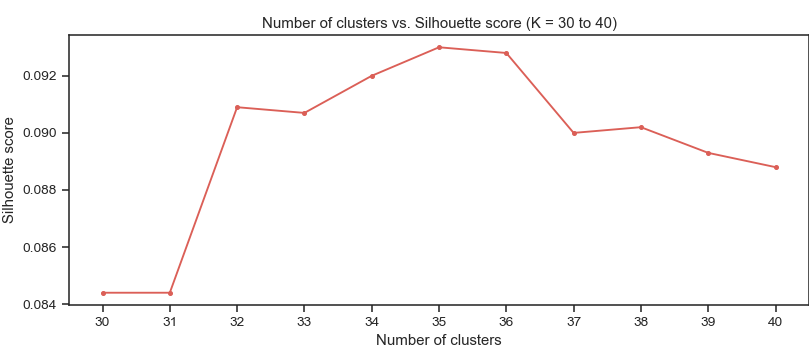

In [70]:
# Plot Number of clusters vs. Silhouette score
plt.figure(figsize=(9,4))

n_clusters = small_n_k_cat
sil_scores = small_scores_cat

plt.plot(n_clusters, sil_scores, '.-')
plt.xticks(n_clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Number of clusters vs. Silhouette score (K = 30 to 40)')

plt.subplots_adjust(left=0.085, right=0.999, bottom=0.15, top=0.9)
plt.show()

When k = 35, the Sihouette score is highest. Let's decide k = 35 for the small_categories. Do clustering on k = 35, and get the labels.

In [71]:
# Agglomerative clustering (n_clusters=35, small_categories)
n_clusters=35

model_cat_35 = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='average')
model_cat_35 = model_cat_35.fit(np_normalized_bow_cat_big)

<IPython.core.display.Javascript object>


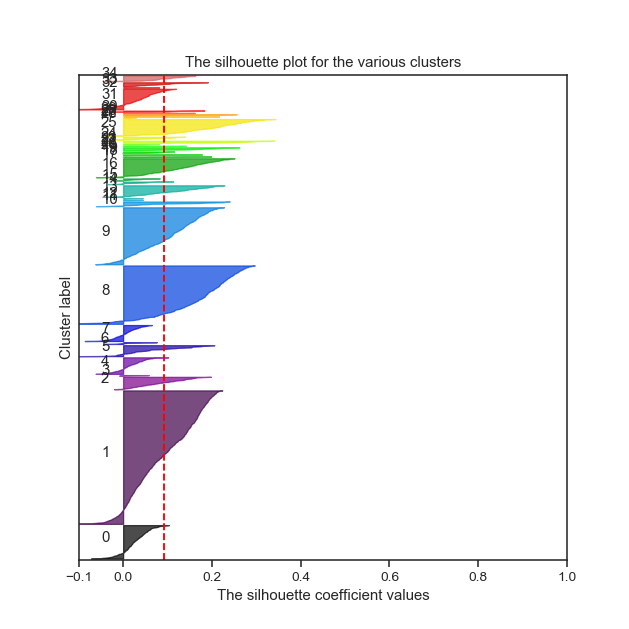

For n_clusters = 35 , The average silhouette_score is : 0.0929838921073329


In [72]:
# Plot silhouette scores
silhouette_plot(model_cat_35.n_clusters_, model_cat_35.labels_, np_normalized_bow_cat_big)

<IPython.core.display.Javascript object>


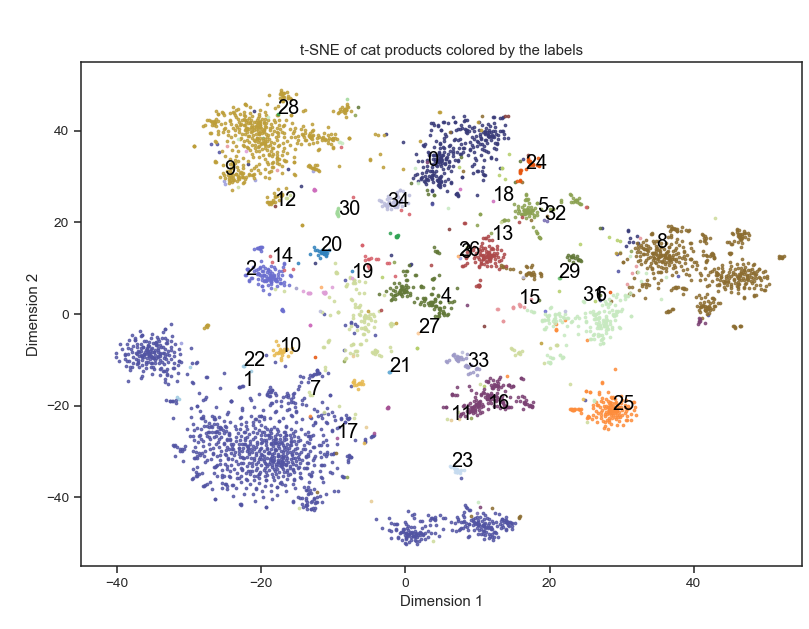

In [73]:
# Scatter plot, colored by the labels
plt.figure(figsize=(9,7))

model = model_cat_35
tsne_features = tsne_features_cat_big

for i in range(model.n_clusters_):
# for i in [32,4,5,27,7,13,12]:  # Cluster_0
# for i in [0,30,28,24,18,34,3,9,6]:  # Cluster_1
# for i in [14,2,19,20,26]:  # Cluster_2
# for i in [10,1,23,22,21,11,17]:  # Cluster_3
# for i in [8,29,31,15]:  # Cluster_4
# for i in [25,33,16]:  # Cluster_5
    plt.scatter(tsne_features[model.labels_ == i][:,0], 
                tsne_features[model.labels_ == i][:,1], 
                s=4, alpha=0.8, c=[cmaps[i]])   
    plt.text(tsne_features[model.labels_ == i][:,0][0],
             tsne_features[model.labels_ == i][:,1][0],
             str(i), color="black", size=16)
        
plt.title('t-SNE of cat products colored by the labels')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.xlim(-45, 55)
plt.ylim(-55, 55)

plt.subplots_adjust(left=0.1, right=0.99, bottom=0.1, top=0.9)
plt.show()

In [74]:
# Add the labels on the product table
df_label_cat_big['label_35'] = model_cat_35.labels_

In [75]:
# Get the frequent words and count the number of products in each cluster
n_clusters = df_label_cat_big['label_35'].nunique()
df_35cluster_cat = pd.DataFrame(columns=['big_category_number', 'small_category_number','frequent words', 'number of products'])

for i in range(n_clusters):
    words = []
    indexes = df_label_cat_big[df_label_cat_big['label_35'] == i].index
    big_category_number = df_label_cat_big[df_label_cat_big['label_35'] == i].iat[0, 2]
    for index in indexes:
        for word in set(new_cat_token_list[index]):
            words.append(word)
    c = Counter(words)
    values, _ = zip(*c.most_common(10))

    df_temp = pd.DataFrame([[big_category_number, i, values, len(indexes)]], 
                                columns=df_35cluster_cat.columns)
    df_35cluster_cat = df_35cluster_cat.append(df_temp) 

df_35cluster_cat.set_index(['big_category_number']).sort_index()

,small_category_number,frequent words,number of products
big_category_number,,,
0,32,"(lock, design, surpris, sturdi, system, line, twist, anim, farm, cant)",3
0,4,"(bed, dog, pad, heat, winter, wash, cover, insid, fit, comfort)",152
0,5,"(door, dog, lock, box, room, flap, fit, cage, side, instruct)",101
0,27,"(husband, handl, microwav, gift, mug, soup, coffe, tea, cup, lover)",2
0,7,"(dog, vet, fit, issu, scratch, bottl, mix, sever, skin, food)",147
0,13,"(carrier, dog, comfort, room, side, fit, carri, trip, travel, vet)",107
0,12,"(instruct, door, unit, stray, batteri, button, number, custom, junk, troubl)",6
1,0,"(scratch, post, sturdi, carpet, tree, play, box, jump, assembl, sit)",307
1,30,"(tent, dog, toy, break, jump, fun, play, tunnel, insid, attach)",11


In [76]:
# Check the products in each cluster
df_label_cat_big[df_label_cat_big['label_35'] == 10].sample(10)

,product_id,product_title,label_12,label_35
2901,721530960,Innovet Pet Products Silicone Pet Feeding SyringeInnovet Pet Products Silicone Pet Feeding Syrin...,3,10
3497,857795771,"PANACUR Dewormer HORSE PASTE 10%, 100mgPANACUR Dewormer HORSE PASTE 10%, 100mgPANACUR Dewormer H...",3,10
1747,419734408,Piller CrusherPiller CrusherPiller CrusherPiller CrusherPiller CrusherPiller CrusherPiller Crush...,3,10
462,120427605,"Azodyl, 60 CapsulesAzodyl, 60 CapsulesAzodyl, 60 CapsulesAzodyl, 60 CapsulesAzodyl, 60 CapsulesA...",3,10
2141,522119868,Sergeant's Vetscription Sure Shot Liquid Wormer Cat 100mlSergeant's Vetscription Sure Shot Liqui...,3,10
1253,306828745,Queen City Animals Concentrated Liquid Vanilla Wormer (Kills Roundworms and Hookworms) Our Super...,3,10
2664,659767381,"Drontal Cat Tablets- 8 Tabs Roundworms,tapeworms,hookworms for CatsDrontal Cat Tablets- 8 Tabs R...",3,10
801,194996896,Pharmapet Pill DispenserPharmapet Pill DispenserPharmapet Pill DispenserPharmapet Pill Dispenser...,3,10
2339,573794560,6-PACK Pill Pockets for Cats CHICKEN 9.6 oz (270 pockets)6-PACK Pill Pockets for Cats CHICKEN 9....,3,10
3355,820348595,"Durvet Wormeze Liquid for Cats and Kittens, 4-OunceDurvet Wormeze Liquid for Cats and Kittens, 4...",3,10


In [77]:
# Label each category title (from the above two tables)
small_category_labels_cat = {32:'other', 4:"bed", 5:"door, cage", 27:'other', 7:"pill, treatment", 13:"carrier, stroller", 
                             12:"other", 
                             0:"scratcher, cat tree", 30:"tent", 28:"step", 24:"perch, shelf", 18:'toy', 
                             34:"nail cap, furniture protector", 3:'other', 9:'toy', 6:"bed", 
                             14:"bed", 2:"collar", 19:"memorial", 20:"harness, leash", 26:"memorial", 
                             10:"pill, treatment", 1:"food, treat, water", 23:"cat grass", 22:"pill, treatment", 
                             21:"flea", 11:"pill, treatment", 17:"scale",
                             8:"litter, litter box", 29:"odor, stain, shampoo", 31:"odor, stain, shampoo", 15:"calming", 
                             25:"flea", 33:"clipper", 16:"brush, comb"}

I noticed several things. Let's take care of these later.  
  
 
- Small_cluster_7 should have been big_category_3. 
- Small_cluster_34 and 21 should have been big_category_5.  
- Small_cluster_30, 28, 24, 6 and 14 should have been big_category_0.  
- Small_cluster_27, 3, 19, 26 and 15 should have been big_category_6.

**4.2.3.3. Make the summary tables**

Now, each of the cat products has a big_category label and a small_category label. In this section, let's make the summary table that has rows representing each product with the id, title, and each category label.  

In [78]:
# Make a new datafeame from df_label_cat_big for summary
df_label_cat_summary = df_label_cat_big[['product_id', 'product_title', 'label_12', 'label_35']]

# Add 'animal' column
df_label_cat_summary['animal'] = 'cat'

print('df_label_cat_summary (first 5 rows):')
df_label_cat_summary.head()

df_label_cat_summary (first 5 rows):


,product_id,product_title,label_12,label_35,animal
0,70064,Perfect Pet Soft Flap Cat Door with Telescoping FramePerfect Pet Soft Flap Cat Door with Telesco...,0,5,cat
1,593896,Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set o...,3,1,cat
2,919291,Basis Pet Made in the USA Low Profile Stainless Steel Cat DishBasis Pet Made in the USA Low Prof...,3,1,cat
3,944764,Alfie Pet by Petoga Couture - Vea 2.0 Slow-Eating Anti-Gulping Pet Food Bowl (for Dogs & Cats)Al...,3,1,cat
4,1124833,Petmate Hooded Cat Litter PanPetmate Hooded Cat Litter PanPetmate Hooded Cat Litter PanPetmate H...,4,8,cat


In [79]:
# Take care of mis-categorized products
for i in range(len(df_label_cat_summary)):
    if df_label_cat_summary.iloc[i, 3] == 7:
        df_label_cat_summary.iloc[i, 2] = 3

    elif df_label_cat_summary.iloc[i, 3] in [34, 21]:
        df_label_cat_summary.iloc[i, 2] = 5

    elif df_label_cat_summary.iloc[i, 3] in [30, 28, 24, 6, 14]:
        df_label_cat_summary.iloc[i, 2] = 0
        
    elif df_label_cat_summary.iloc[i, 3] in [27, 3, 19, 26, 15]:
        df_label_cat_summary.iloc[i, 2] = 6

# Replace the category numbers with the names
df_label_cat_summary = df_label_cat_summary.replace({'label_12': big_category_labels_cat,
                                                     'label_35': small_category_labels_cat})
# Rename the columns
df_label_cat_summary = df_label_cat_summary.rename(columns={'label_12': 'big_category', 'label_35': 'small_category'})

print('df_label_cat_summary (first 5 rows):')
df_label_cat_summary.head()

df_label_cat_summary (first 5 rows):


,product_id,product_title,big_category,small_category,animal
0,70064,Perfect Pet Soft Flap Cat Door with Telescoping FramePerfect Pet Soft Flap Cat Door with Telesco...,"door, cage, carrier, bed","door, cage",cat
1,593896,Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set o...,"food, treatment","food, treat, water",cat
2,919291,Basis Pet Made in the USA Low Profile Stainless Steel Cat DishBasis Pet Made in the USA Low Prof...,"food, treatment","food, treat, water",cat
3,944764,Alfie Pet by Petoga Couture - Vea 2.0 Slow-Eating Anti-Gulping Pet Food Bowl (for Dogs & Cats)Al...,"food, treatment","food, treat, water",cat
4,1124833,Petmate Hooded Cat Litter PanPetmate Hooded Cat Litter PanPetmate Hooded Cat Litter PanPetmate H...,"litter, odor, stain","litter, litter box",cat


Let's make df_label_cat_other having the same columns as df_label_cat_summary, and take care of the mis-categorized products. Remember them:

- Cluster_8 is not for cats, but fish.  
- Cluster_10 is a kind of toy.

In [80]:
# Make a new datafeame from df_label_cat_other for summary
df_other_cat = df_label_cat_other[['product_id', 'product_title', 'label_12']]

# Add 'big_category' column
df_other_cat['big_category'] = 'other'

# Add 'animal' column
df_other_cat['animal'] = 'cat'

# Take care of mis-categorized products 
for i in range(len(df_other_cat)):
    # Column_2 is 'label_12'
    if df_other_cat.iloc[i, 2] == 8:
        # Column_3 is 'big_categories'
        df_other_cat.iloc[i, 3] = 'fish, reptile'
        # Column_4 is 'animal'
        df_other_cat.iloc[i, 4] = 'other'
    
    elif df_other_cat.iloc[i, 2] == 10:
        df_other_cat.iloc[i, 3] = 'toy, scratcher, cat tree' 

# Replace the category numbers into the names
df_other_cat = df_other_cat.replace({'label_12': other_category_labels_cat})

# Rename the column
df_other_cat = df_other_cat.rename(columns={'label_12': 'small_category'})

print('df_other_cat (first 5 rows):')
df_other_cat.head()

df_other_cat (first 5 rows):


,product_id,product_title,small_category,big_category,animal
62,12304637,"Wall Mounted Fish Bowl Bubble for Goldfish & Beta or Hanging Terrarium with Exclusive ""Lets Get ...",aquarium,"fish, reptile",other
73,14334855,"Cholla Wood, 3 Nice Pieces of Aquarium Driftwood Decoration by Aquatic ArtsCholla Wood, 3 Nice P...",aquarium,"fish, reptile",other
161,35498715,Lightahead Artificial Mini Aquarium Fish Tank Multi Color LED Swimming Fish Tank with BubblesLig...,aquarium,"fish, reptile",other
224,53604498,"OurPets Bouncy North-American Catnip Bubbles, 8-OunceOurPets Bouncy North-American Catnip Bubble...",toy,"toy, scratcher, cat tree",cat
468,121923547,"Kookamunga Krazee Kitty Catnip Bubbles, 5 ozKookamunga Krazee Kitty Catnip Bubbles, 5 ozKookamun...",toy,"toy, scratcher, cat tree",cat


In [81]:
# Merge df_label_cat_summary and df_other_cat
df_label_cat_summary = df_label_cat_summary.append(df_other_cat)

print('df_label_cat_summary (first 5 rows):')
df_label_cat_summary.head()

df_label_cat_summary (first 5 rows):


,product_id,product_title,big_category,small_category,animal
0,70064,Perfect Pet Soft Flap Cat Door with Telescoping FramePerfect Pet Soft Flap Cat Door with Telesco...,"door, cage, carrier, bed","door, cage",cat
1,593896,Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set o...,"food, treatment","food, treat, water",cat
2,919291,Basis Pet Made in the USA Low Profile Stainless Steel Cat DishBasis Pet Made in the USA Low Prof...,"food, treatment","food, treat, water",cat
3,944764,Alfie Pet by Petoga Couture - Vea 2.0 Slow-Eating Anti-Gulping Pet Food Bowl (for Dogs & Cats)Al...,"food, treatment","food, treat, water",cat
4,1124833,Petmate Hooded Cat Litter PanPetmate Hooded Cat Litter PanPetmate Hooded Cat Litter PanPetmate H...,"litter, odor, stain","litter, litter box",cat


This df_label_cat_summary shows the category label of each product for cats.  That's all for cat products!

### 4.3. Other categpry

Let's do clustering of other category in the same way as dog and cat categories.

#### 4.3.1. Load data

Token list:

In [82]:
# Load the token list
pet_token_list = []
with open("other_token_list.csv", "r", encoding="UTF-8") as f:
    reader = csv.reader(f) 
    for r in reader: 
        pet_token_list.append(r)
        
print('pet_token_list (first 5 tokens of the first product):', pet_token_list[0][:5])
print('Number of products:', len(pet_token_list))
print('Number of unique tokens:', len(set(token for review in pet_token_list for token in review)))

pet_token_list (first 5 tokens of the first product): ['lint', 'roller', 'hair', 'cloth', 'pick']
Number of products: 4388
Number of unique tokens: 5914


ID-title table:

In [83]:
# Load the product table
df_pet_id_name = pd.read_csv("df_other_id_name.csv")

print('df_pet_id_name (first 5 products):')
df_pet_id_name.head()

df_pet_id_name (first 5 products):


,product_id,product_title
0,674575,Scotch Pet Hair Roller 839RScotch Pet Hair Roller 839RScotch Pet Hair Roller 839RScotch Pet Hair...
1,690871,Petco Brooklyn 55 Gallon Metal Tank StandPetco Brooklyn 55 Gallon Metal Tank StandPetco Brooklyn...
2,1299419,Kaytee Forti Diet Pro Health Guinea Pig FoodKaytee Forti Diet Pro Health Guinea Pig FoodKaytee F...
3,1304120,Amzdeal® 12 Inch Blue led light Underwater LED Aquarium Light Strip & Airstone for Aquarium Fish...
4,1469725,"Fetch for Pets Bulk Nail Files, 6-PackFetch for Pets Bulk Nail Files, 6-PackFetch for Pets Bulk ..."


#### 4.3.2. Vectorization

Pet_token_list has 5,914 kinds of tokens. Additionaly, I use bigrams as the dog dataset. To control the number of tokens, tokens appearing less than 6 times in the total documents are cut.

In [84]:
# Create CountVectorizer object 
cvectorizer_pet = CountVectorizer(tokenizer=dummy_tokened,lowercase=False, min_df=6, ngram_range=(1, 2))
bow_pet = cvectorizer_pet.fit_transform(pet_token_list)

# Get the feature names
feature_names_pet = cvectorizer_pet.get_feature_names()

# Show the shape of bow_matrix
print('BOW matrix: bow_pet')
print('Matrix shape:', bow_pet.shape)

BOW matrix: bow_pet
Matrix shape: (4388, 5156)


In [85]:
# Normarize the bow matrix
normalized_bow_pet = normalize(bow_pet)

# Change the normalizer bow matrix into np.array to use for AgglomerativeClustering()
np_normalized_bow_pet = normalized_bow_pet.toarray()

print('Normarized BOW matrix: np_normalized_bow_pet')
print('Matrix shape:', np_normalized_bow_pet.shape)

Normarized BOW matrix: np_normalized_bow_pet
Matrix shape: (4388, 5156)


In [86]:
# Create a t-SNE instance
tsne_pet = TSNE(perplexity=50, learning_rate=800, random_state=10)

# Apply fit_transform to samples
tsne_features_pet = tsne_pet.fit_transform(normalized_bow_pet)

<IPython.core.display.Javascript object>


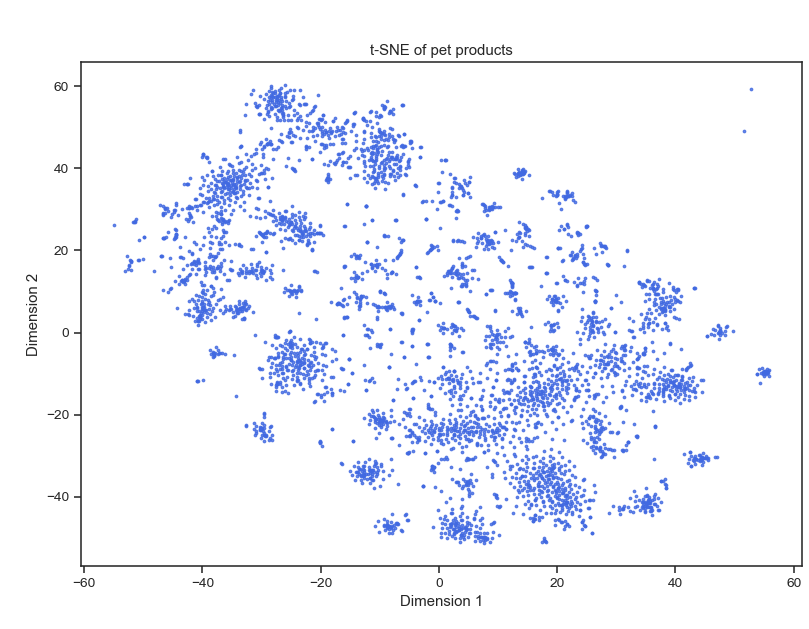

In [87]:
# Scatter plot of t-SNE
plt.figure(figsize=(9,7))
tsne_features = tsne_features_pet

plt.scatter(tsne_features[:,0], tsne_features[:,1], s=4, alpha=0.8, c='royalblue')   

plt.title('t-SNE of pet products')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.subplots_adjust(left=0.1, right=0.99, bottom=0.1, top=0.9)
plt.show()

There seems to be less than 6 big clusters, and many small and mini clusters. Now, let's start hierarchical clustering!

#### 4.3.3. Hierarchical clustering

First, I would like to divide the data into less than 6 categories. Second, each of the big_categories will be devided into subcategories.

**4.3.3.1. Big categories**

In [88]:
# Agglomeral clustering setting distance_threshold=0 to compute the full tree
model_pet = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='cosine', linkage='average')
model_pet = model_pet.fit(np_normalized_bow_pet)

<IPython.core.display.Javascript object>


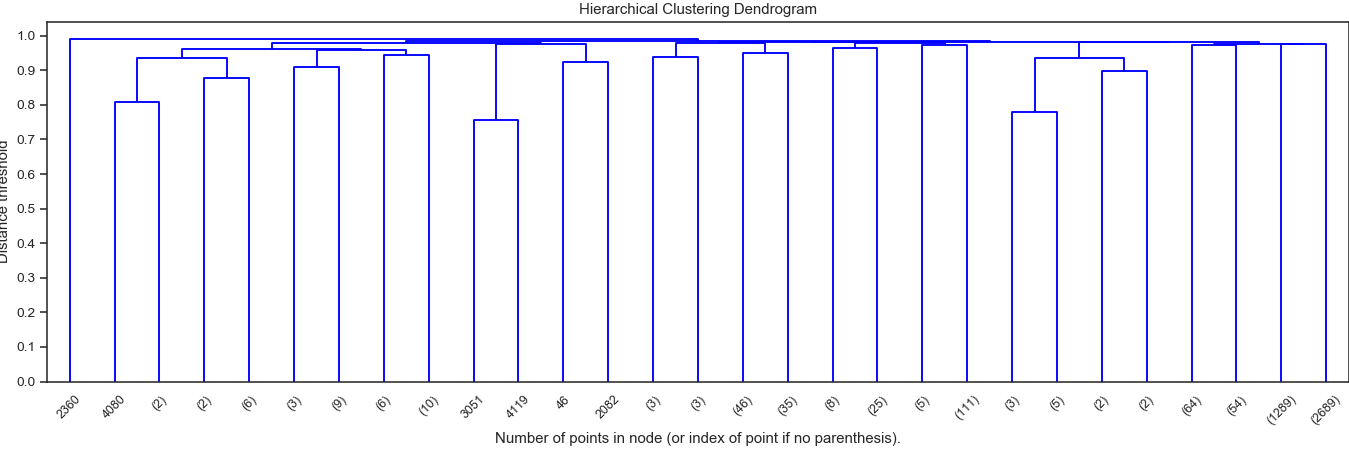

In [89]:
# plot the top five levels of the dendrogram
plt.figure(figsize=(15,5))

plot_dendrogram(model_pet, truncate_mode='level', p=5)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Distance threshold")
plt.yticks([i/10 for i in range(0,11,1)])

plt.subplots_adjust(left=0.035, right=0.999, bottom=0.15, top=0.95)
plt.show()

According to the dendrogram above, some mini clusters join up with the big clusters in the upper course of the dendrogram. Let's collect them as the "other" group.
I would like to divide the data into less than 6 big_categories. So, let's check the silhouette scores from k = 5 to 15.

In [90]:
# Agglomeral clustering from k = 5 to 15 
n_k_pet, scores_pet, n_samples_pet  = aggclus_silscore_nsamples(5, 15, 1, np_normalized_bow_pet)

C:\Users\namik\Anaconda3\envs\springboard1\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


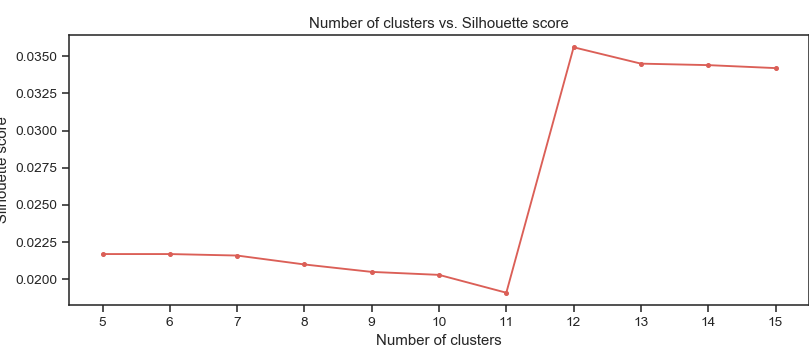

In [91]:
# Plot Number of clusters vs. Silhouette score
plt.figure(figsize=(9,4))

n_clusters = n_k_pet
sil_scores = scores_pet

plt.plot(n_clusters, sil_scores, '.-')
plt.xticks(n_clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Number of clusters vs. Silhouette score')

plt.subplots_adjust(left=0.085, right=0.999, bottom=0.15, top=0.9)
plt.show()

When k = 12, the score is the maximum. Let's check the number of the big clusters.

In [92]:
# Count the number of samples in the cluster
for k in [12]:
    n_cluster = k - 5
    count = 0
    for i in range(len(n_samples_pet[n_cluster])):
        if n_samples_pet[n_cluster][i] > 100:
            count += 1
    print('k =', k)
    print(n_samples_pet[n_cluster])
    print('Number of clusters more than 100 samples:', count)
    print('')

k = 12
{0: 2689, 1: 118, 2: 116, 3: 81, 4: 39, 5: 1289, 6: 33, 7: 1, 8: 6, 9: 12, 10: 2, 11: 2}
Number of clusters more than 100 samples: 4



There are two big clusters, three small clusters, and several mini clusters. Because this dataset is about 'other', the diversity of product kinds could highly diverse. Let's look closely k = 12, and see what is in each cluster.

In [93]:
# Agglomeral clustering; k = 12
model_pet_12 = AgglomerativeClustering(n_clusters=12, affinity='cosine', linkage='average')
model_pet_12 = model_pet_12.fit(np_normalized_bow_pet)

C:\Users\namik\Anaconda3\envs\springboard1\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


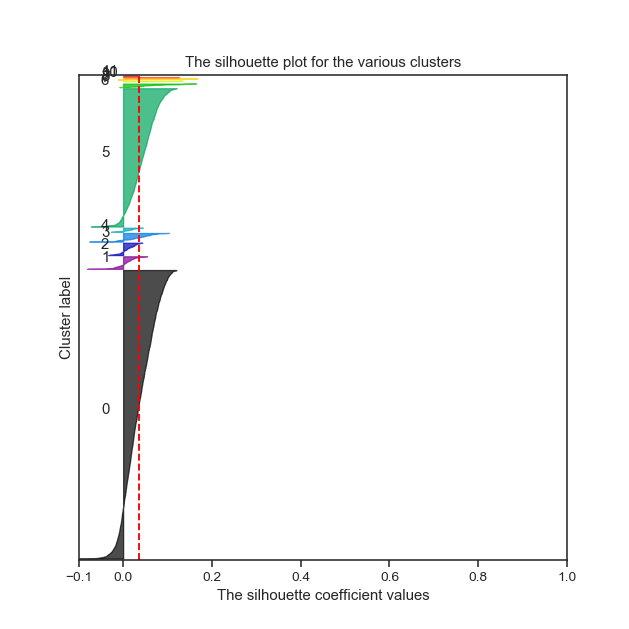

For n_clusters = 12 , The average silhouette_score is : 0.03564812239805721


In [94]:
# Silhouette plot
silhouette_plot(model_pet_12.n_clusters_, model_pet_12.labels_, np_normalized_bow_pet)

C:\Users\namik\Anaconda3\envs\springboard1\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


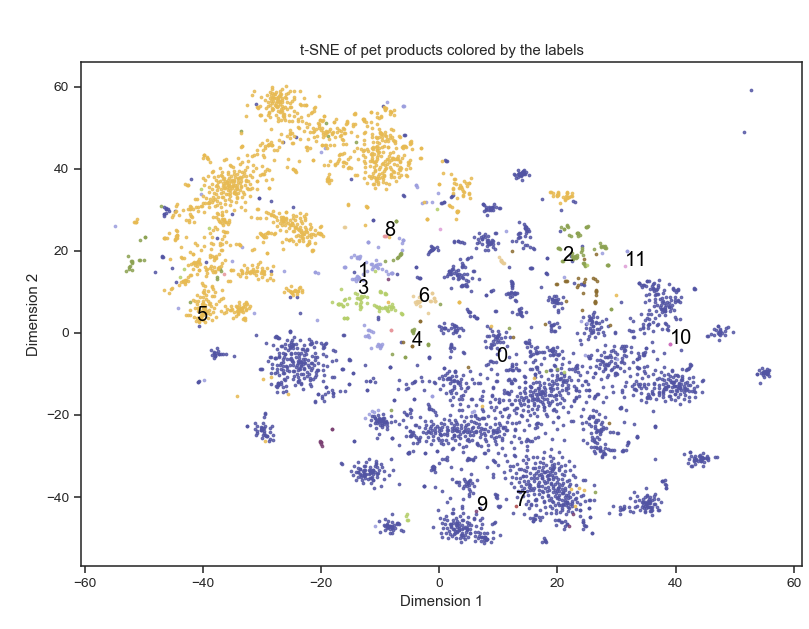

In [95]:
# t-SNE of pet products colored by the labels
plt.figure(figsize=(9,7))

model = model_pet_12
tsne_features = tsne_features_pet

for i in range(model.n_clusters_):
    plt.scatter(tsne_features[model.labels_ == i][:,0], 
                tsne_features[model.labels_ == i][:,1], 
                s=4, alpha=0.8, c=[cmap1((i+1)/model.n_clusters_)])   
    plt.text(tsne_features[model.labels_ == i][:,0][0],
             tsne_features[model.labels_ == i][:,1][0],
             str(i), color="black", size=16)
        
plt.title('t-SNE of pet products colored by the labels')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.subplots_adjust(left=0.1, right=0.99, bottom=0.1, top=0.9)
plt.show()

In [96]:
# Apply the labels to the product table
df_label_pet = df_pet_id_name[['product_id', 'product_title']]
df_label_pet['label_12'] = model_pet_12.labels_

# Count the number of products in each clusters
frequent_words(df_label_pet, 'label_12', pet_token_list)

,frequent words,number of products
cluster number,,
0,"(tank, water, gallon, aquarium, fish, filter, plant, color, food, pump)",2689
1,"(smell, spray, hand, area, effect, bottl, water, result, sinc, vet)",118
2,"(fit, comfort, car, color, side, door, head, strap, materi, clip)",116
3,"(hair, groom, cut, blade, brush, clipper, fit, comb, oster, tool)",81
4,"(beauti, gift, son, chain, hang, seller, tag, make, color, person)",39
5,"(bird, cage, food, eat, parrot, toy, seed, rabbit, treat, guinea)",1289
6,"(batteri, collar, fit, box, leash, shock, charg, train, hand, origin)",33
7,"(benefit, meter, effect, reus, fulli, bio, canist, nitrogen, matrix, fin)",1
8,"(goat, milk, watch, administ, right, box, dwarf, side, duti, edg)",6


According to the frequent tokens, the big two clusters are about fish (cluster_0) and birds & rabbits (cluster_5). I can imagine there are several common products among birds and rabbits such as cages, cleaning items, and food. So, I think k = 12 is appropriate. Let's look each cluster closely, and make sure that.

In [97]:
# Check the products in each cluster
df_label_pet[df_label_pet['label_12'] == 0].sample(10)

,product_id,product_title,label_12
283,67280898,Bean-e-doo Mastic Remover 1 Gallon by Franmar ChemicalBean-e-doo Mastic Remover 1 Gallon by Fran...,0
84,22222862,FA18X Aquarium Acclimation System by DoradonFA18X Aquarium Acclimation System by DoradonFA18X Aq...,0
362,84496643,TRIPLE COMBO PACK - 10 Sakura Fire Red Cherry Shrimp (Breeding Age Young Adults) + 5 Tiger Nerit...,0
1296,290092374,Kent Marine Pro-Scraper IIKent Marine Pro-Scraper IIKent Marine Pro-Scraper IIKent Marine Pro-Sc...,0
3226,735683407,"8 in 1 Ultra-Blend Select Complete Nutrition Ferret Diet,5Lbs8 in 1 Ultra-Blend Select Complete ...",0
2648,601377251,Python Brass Snap Connector for AquariumPython Brass Snap Connector for AquariumPython Brass Sna...,0
1382,311015481,"PENN PLAX Add-A-Stone Air Pump Accessories, 10-Inch by 2-InchPENN PLAX Add-A-Stone Air Pump Acce...",0
2532,573323615,Fluker's High-Calcium Cricket DietFluker's High-Calcium Cricket DietFluker's High-Calcium Cricke...,0
2521,571138392,Coralife 2-Pack BioCube Filter Cartridge for AquariumCoralife 2-Pack BioCube Filter Cartridge fo...,0
1217,271044944,"Aqueon 100106035 Tropical Flakes, 3-PoundsAqueon 100106035 Tropical Flakes, 3-PoundsAqueon 10010...",0


According to the Silhouette plot, the t-SNE image with the labels, the frequent words, and browsing the product titles in each cluster, the big two clusters have individual features, and I have evaluated they are appropriate as big_categories respectively. As a result, we have had 2 big_categories. Let's think about the rest of clusters as 'other' group. However, some of them also have a unique character. I'll also label them.

In [98]:
# Label each category title (from the above two tables)
big_category_labels_pet = {0:"fish, reptile", 1:"other", 2:"other", 3:"other", 4:"other", 
                           5:"bird, rabbit, hamster", 6:"other", 7:"fish, reptile", 8:"other", 
                           9:"fish, reptile", 10:"other", 11:"other"}

# Label each category title (from the above table)
other_category_labels_pet = {1:"treatment", 2:"other", 3:"brush, comb, clipper", 4:"memorial, tag", 6:"training", 
                             7:"aquarium", 8:"other", 9:"aquarium", 10:"other", 11:"other"}

I noticed several things. Let's take care of these later.  

- Cluster_6 is for dogs, especially for training. 
- Cluster_7 and 9 are for fish.


Now, let's extract the big 2 clusters (cluster_0 and 5) for farther clustering.

In [99]:
# Divide the product table into two: the big clusters, the other group
big_clusters_pet = [0, 5]
df_label_pet_big = pd.DataFrame()
df_label_pet_other = pd.DataFrame()

for i in range(len(df_label_pet)):
    if i in big_clusters_pet:
        df_label_pet_big = df_label_pet_big.append(df_label_pet[df_label_pet['label_12'] == i])
    else:
        df_label_pet_other = df_label_pet_other.append(df_label_pet[df_label_pet['label_12'] == i])

# Sort by the indexes
df_label_pet_big = df_label_pet_big.sort_index()
df_label_pet_other = df_label_pet_other.sort_index()

id-title table for the big clusters:

In [100]:
print(len(df_label_pet_big), 'products')
print('df_label_pet_big (first 5 products):')
df_label_pet_big.head()

3978 products
df_label_pet_big (first 5 products):


,product_id,product_title,label_12
1,690871,Petco Brooklyn 55 Gallon Metal Tank StandPetco Brooklyn 55 Gallon Metal Tank StandPetco Brooklyn...,0
2,1299419,Kaytee Forti Diet Pro Health Guinea Pig FoodKaytee Forti Diet Pro Health Guinea Pig FoodKaytee F...,5
3,1304120,Amzdeal® 12 Inch Blue led light Underwater LED Aquarium Light Strip & Airstone for Aquarium Fish...,0
5,1926454,API 1500 Watt 3 In 1 De-Icer DT15API 1500 Watt 3 In 1 De-Icer DT15API 1500 Watt 3 In 1 De-Icer...,0
6,2365091,AQUATOP AC/DC Single Battery Operated Air PumpAQUATOP AC/DC Single Battery Operated Air PumpAQUA...,0


id-title table for the other clusters:

In [101]:
print(len(df_label_pet_other), 'products')
print('df_label_pet_other (first 5 products):')
df_label_pet_other.head()

410 products
df_label_pet_other (first 5 products):


,product_id,product_title,label_12
0,674575,Scotch Pet Hair Roller 839RScotch Pet Hair Roller 839RScotch Pet Hair Roller 839RScotch Pet Hair...,3
4,1469725,"Fetch for Pets Bulk Nail Files, 6-PackFetch for Pets Bulk Nail Files, 6-PackFetch for Pets Bulk ...",2
7,2425297,"Parisian Pet I Love Daddy Dog T-Shirt, SmallParisian Pet I Love Daddy Dog T-Shirt, SmallParisian...",2
18,4493925,RECARO Performance BOOSTER Highback Booster Car Seat - RoseRECARO Performance BOOSTER Highback B...,2
46,10799804,Single Feather SmudgerSingle Feather SmudgerSingle Feather SmudgerSingle Feather SmudgerSingle F...,11


Also, let's separate the bow matrix and t-SNE features of the big clusters.

In [102]:
# Get the normalized bow matrix of the big clusters
np_normalized_bow_pet_big = np.array([np_normalized_bow_pet[i] 
                                          for i in range(len(np_normalized_bow_pet)) if i in df_label_pet_big.index])

print('Normarized BOW matrix of big_categories: np_normalized_bow_pet_big')
print('Matrix shape:', np_normalized_bow_pet_big.shape)

Normarized BOW matrix of big_categories: np_normalized_bow_pet_big
Matrix shape: (3978, 5156)


In [103]:
# Get the t-SNE features of the big clusters
tsne_features_pet_big = np.array([tsne_features_pet[i] 
                                      for i in range(len(tsne_features_pet))if i in df_label_pet_big.index])

print('T-SNE features of big_categories: tsne_features_pet_big')
print('Feature shape:', tsne_features_pet_big.shape)

T-SNE features of big_categories: tsne_features_pet_big
Feature shape: (3978, 2)


**4.3.3.2. Small categories**

Check the silhouette scores from k = 15 to 50 roughly to get some ideas to decide the number of the small_categories.

In [104]:
# Agglomeral clustering; k = 15 to 50 
rough_n_k_pet, rough_scores_pet, _ = aggclus_silscore_nsamples(5, 50, 5, np_normalized_bow_pet_big)

C:\Users\namik\Anaconda3\envs\springboard1\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


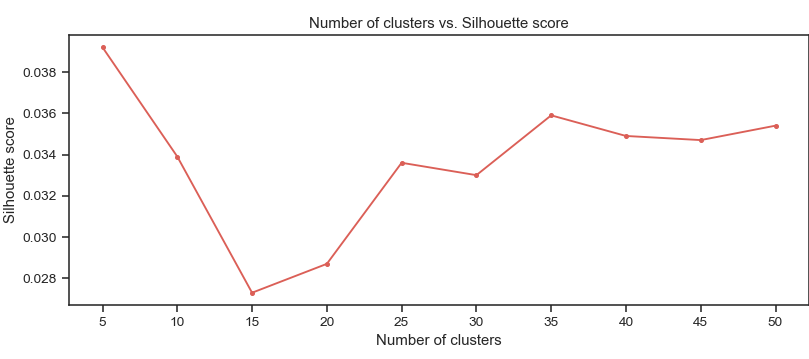

In [105]:
# Plot Number of clusters vs. Silhouette score
plt.figure(figsize=(9,4))

n_clusters = rough_n_k_pet
sil_scores = rough_scores_pet

plt.plot(n_clusters, sil_scores, '.-')
plt.xticks(n_clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Number of clusters vs. Silhouette score')

plt.subplots_adjust(left=0.085, right=0.999, bottom=0.15, top=0.9)
plt.show()

One peak is around k = 35. Let's check the scores finely from k = 30 to 40 to choose k for the small_categories.

In [106]:
# Agglomeral clustering; k = 30 to 40 
small_n_k_pet, small_scores_pet, _ = aggclus_silscore_nsamples(30, 40, 1, np_normalized_bow_pet_big)

C:\Users\namik\Anaconda3\envs\springboard1\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


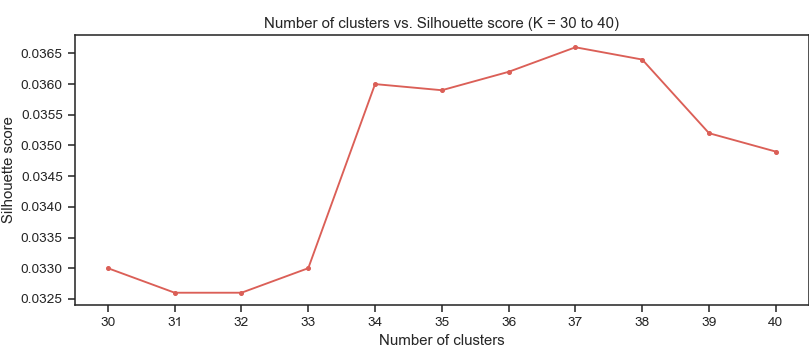

In [107]:
# Plot Number of clusters vs. Silhouette score
plt.figure(figsize=(9,4))

n_clusters = small_n_k_pet
sil_scores = small_scores_pet

plt.plot(n_clusters, sil_scores, '.-')
plt.xticks(n_clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Number of clusters vs. Silhouette score (K = 30 to 40)')

plt.subplots_adjust(left=0.092, right=0.999, bottom=0.15, top=0.9)
plt.show()

When k = 37, the Sihouette score is highest. Let's decide k = 37 for the small_categories. Do clustering on k = 37, and get the labels.

In [108]:
# Agglomerative clustering (n_clusters=37, small_categories)
n_clusters=37

model_pet_37 = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='average')
model_pet_37 = model_pet_37.fit(np_normalized_bow_pet_big)

C:\Users\namik\Anaconda3\envs\springboard1\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


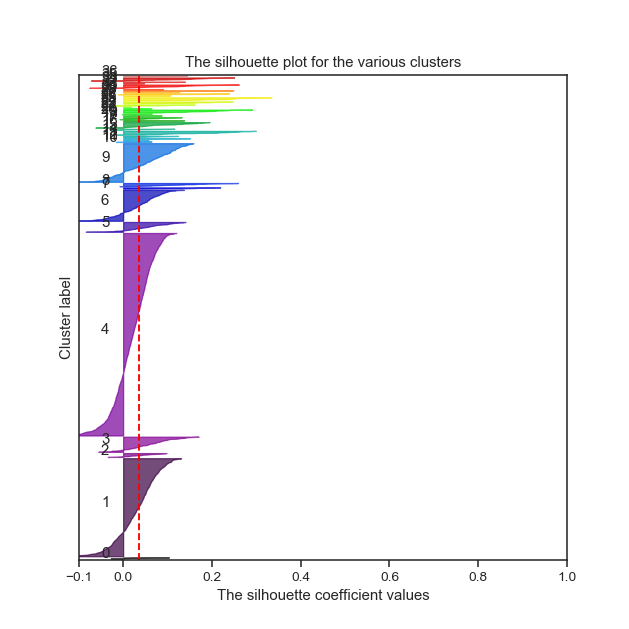

For n_clusters = 37 , The average silhouette_score is : 0.03657825698406181


In [109]:
# Plot silhouette scores
silhouette_plot(model_pet_37.n_clusters_, model_pet_37.labels_, np_normalized_bow_pet_big)

C:\Users\namik\Anaconda3\envs\springboard1\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


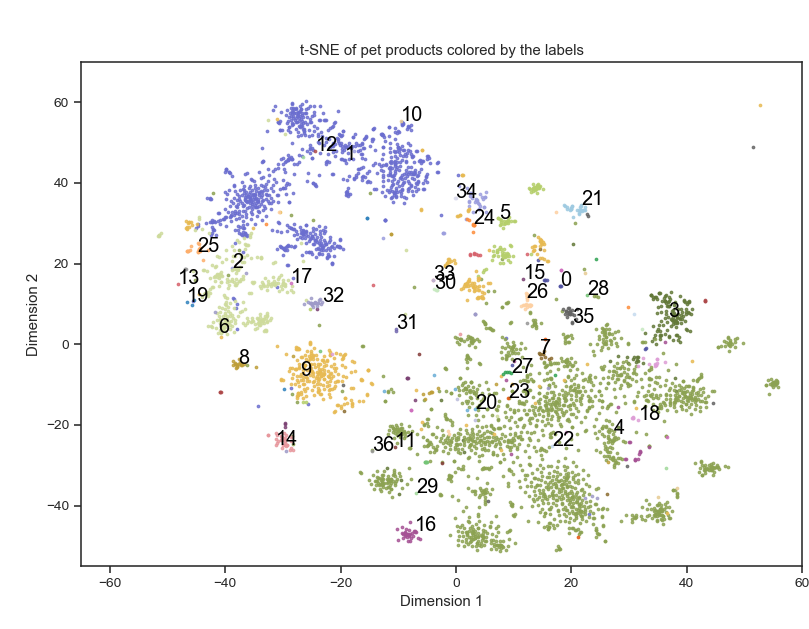

In [110]:
# t-SNE of pet products colored by the labels
plt.figure(figsize=(9,7))

model = model_pet_37
tsne_features = tsne_features_pet_big

for i in range(model.n_clusters_):
# for i in [0,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,20,22,23,26,27,28,29,30,31,33,35,36]:  # Cluster_0
# for i in [1,2,6,19,21,24,25,32,34]:  # Cluster_5
    plt.scatter(tsne_features[model.labels_ == i][:,0], 
                tsne_features[model.labels_ == i][:,1], 
                s=4, alpha=0.8, c=[cmaps[i+1]], label=i)   
    plt.text(tsne_features[model.labels_ == i][:,0][0],
             tsne_features[model.labels_ == i][:,1][0],
             str(i), color="black", size=16)

plt.title('t-SNE of pet products colored by the labels')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.xlim(-65, 60)
plt.ylim(-55, 70)

plt.subplots_adjust(left=0.1, right=0.99, bottom=0.1, top=0.9)
plt.show()

In [111]:
# Add the labels on the product table
df_label_pet_big['label_37'] = model_pet_37.labels_

In [112]:
# Get the frequent words and count the number of products in each cluster
n_clusters = df_label_pet_big['label_37'].nunique()
df_37cluster_pet = pd.DataFrame(columns=['big_category_number', 'small_category_number',
                                         'frequent words', 'number of products'])

for i in range(n_clusters):
    words = []
    indexes = df_label_pet_big[df_label_pet_big['label_37'] == i].index
    big_category_number = df_label_pet_big[df_label_pet_big['label_37'] == i].iat[0, 2]
    for index in indexes:
        for word in set(pet_token_list[index]):
            words.append(word)
    c = Counter(words)
    values, _ = zip(*c.most_common(10))

    df_temp = pd.DataFrame([[big_category_number, i, values, len(indexes)]], 
                                columns=df_37cluster_pet.columns)
    df_37cluster_pet = df_37cluster_pet.append(df_temp) 

df_37cluster_pet.set_index(['big_category_number']).sort_index()

,small_category_number,frequent words,number of products
big_category_number,,,
0,0,"(terrarium, beauti, digit, humid, temp, instruct, moss, plant, fit, seller)",11
0,33,"(treatment, warn, spot, result, aliv, vet, sever, concentr, tip, alon)",3
0,31,"(serv, purpos, tool, manner, busi, thx, home, forev, blade, guard)",2
0,30,"(eye, stain, cavali, face, solut, wash, hair, wipe, worri, charl)",5
0,29,"(scale, water, eye, area, degre, boil, insid, magnifi, temp, danger)",3
0,28,"(seal, bucket, gamma, lid, storag, content, water, food, fit, cover)",7
0,27,"(side, junk, tank, support, descript, gap, scratch, care, stay, make)",7
0,26,"(crab, hermit, shell, food, tank, eat, hermi, water, bag, shape)",28
0,23,"(readi, sinc, parasit, tank, display, pack, bag, pod, gill, warn)",3


In [113]:
# Check the products in each cluster
df_label_pet_big[df_label_pet_big['label_37'] == 0].sample(10)

,product_id,product_title,label_12,label_37
3976,903038769,"Avianweb Digital Thermo Hygrometer, Mini, BlackAvianweb Digital Thermo Hygrometer, Mini, BlackAv...",0,0
2090,473957770,Exo Terra Compact Incandescent FixtureExo Terra Compact Incandescent FixtureExo Terra Compact In...,0,0
2129,481835720,Zoo Med Naturalistic Terrarium HoodZoo Med Naturalistic Terrarium HoodZoo Med Naturalistic Terra...,0,0
4127,937730508,Exo Terra Terrarium PlantExo Terra Terrarium PlantExo Terra Terrarium PlantExo Terra Terrarium P...,0,0
750,168473621,9GreenBox - Terrarium/Fairy Garden Kit - Create Your Own Living Terrarium or Fairy Garden9GreenB...,0,0
3968,900610966,Zilla Terrarium Digital ThermometerZilla Terrarium Digital ThermometerZilla Terrarium Digital Th...,0,0
2614,594657150,"Exo Terra Digital Thermometer with Probe, Celsius and FahrenheitExo Terra Digital Thermometer wi...",0,0
3154,720430757,Reptology Reptile Hygrometer Humidity and Temperature Sensor GaugesReptology Reptile Hygrometer ...,0,0
491,111385414,Terrarium/Fairy Garden Kit - Create Your Own Living TerrariumTerrarium/Fairy Garden Kit - Create...,0,0
2916,662867885,Exo Terra Digital Combination Thermometer/HygrometerExo Terra Digital Combination Thermometer/Hy...,0,0


In [114]:
# Label each category title (from the above two tables)
small_category_labels_pet = {0:"terrarium", 33:"aquarium", 31:"other", 
                             30:"terrarium", 29:"aquarium", 28:"aquarium", 27:"other", 26:"crustacean",
                             23:"aquarium", 22:"aquarium", 20:"aquarium", 35:"crustacean",  17:"other", 16:"aquarium", 
                             15:"other", 18:"aquarium", 13:"terrarium", 3:"terrarium", 
                             4:"aquarium", 5:"food (reptile)", 14:"waste bag", 8:"bowl", 7:"aquarium", 10:"other", 
                             11:"other", 12:"other", 9:"food (fish, turtle)", 36:"rabbit, hamster",
                             21:"chicken", 24:"chicken", 25:"chinchila", 6:"rabbit, hamster", 
                             19:"other", 2:"chicken", 32:"litter, bedding", 1:"bird", 34:"other"}

I noticed several things. Let's take care of these later.  

- Small_cluster_17, 15, 14, 8, 12 are in big_category_0, but should have been big_category_1.
- Small_cluster_34 is in big_category_0, but should have been big_category_1.
- Small_cluster_36 is in big_category_0, but should have been big_category_5.

**4.3.3.3. Make the summary tables**

Now, each product has a big_category label and a small_category label. In this section, let's make the summary table that has rows representing each product with the id, title, and each category label.  

In [115]:
# Make a new datafeame from df_label_pet_big for summary
df_label_pet_summary = df_label_pet_big[['product_id', 'product_title', 'label_12', 'label_37']]

# Add 'animal' column
df_label_pet_summary['animal'] = 'other'

print('df_label_pet_summary (first 5 rows):')
df_label_pet_summary.head()

df_label_pet_summary (first 5 rows):


,product_id,product_title,label_12,label_37,animal
1,690871,Petco Brooklyn 55 Gallon Metal Tank StandPetco Brooklyn 55 Gallon Metal Tank StandPetco Brooklyn...,0,27,other
2,1299419,Kaytee Forti Diet Pro Health Guinea Pig FoodKaytee Forti Diet Pro Health Guinea Pig FoodKaytee F...,5,6,other
3,1304120,Amzdeal® 12 Inch Blue led light Underwater LED Aquarium Light Strip & Airstone for Aquarium Fish...,0,4,other
5,1926454,API 1500 Watt 3 In 1 De-Icer DT15API 1500 Watt 3 In 1 De-Icer DT15API 1500 Watt 3 In 1 De-Icer...,0,4,other
6,2365091,AQUATOP AC/DC Single Battery Operated Air PumpAQUATOP AC/DC Single Battery Operated Air PumpAQUA...,0,4,other


In [116]:
# Take care of mis-categorized products
for i in range(len(df_label_pet_summary)):
    if df_label_pet_summary.iloc[i, 3] in [17, 15, 14, 8, 12, 34]:
        df_label_pet_summary.iloc[i, 2] = 1
    elif df_label_pet_summary.iloc[i, 3] == 36:
        df_label_pet_summary.iloc[i, 2] = 5
        
# Replace the category numbers with the names
df_label_pet_summary = df_label_pet_summary.replace({'label_12': big_category_labels_pet,
                                             'label_37': small_category_labels_pet})
# Rename the columns
df_label_pet_summary = df_label_pet_summary.rename(columns={'label_12': 'big_category', 'label_37': 'small_category'})

print('df_label_pet_summary (first 5 rows):')
df_label_pet_summary.head()

df_label_pet_summary (first 5 rows):


,product_id,product_title,big_category,small_category,animal
1,690871,Petco Brooklyn 55 Gallon Metal Tank StandPetco Brooklyn 55 Gallon Metal Tank StandPetco Brooklyn...,"fish, reptile",other,other
2,1299419,Kaytee Forti Diet Pro Health Guinea Pig FoodKaytee Forti Diet Pro Health Guinea Pig FoodKaytee F...,"bird, rabbit, hamster","rabbit, hamster",other
3,1304120,Amzdeal® 12 Inch Blue led light Underwater LED Aquarium Light Strip & Airstone for Aquarium Fish...,"fish, reptile",aquarium,other
5,1926454,API 1500 Watt 3 In 1 De-Icer DT15API 1500 Watt 3 In 1 De-Icer DT15API 1500 Watt 3 In 1 De-Icer...,"fish, reptile",aquarium,other
6,2365091,AQUATOP AC/DC Single Battery Operated Air PumpAQUATOP AC/DC Single Battery Operated Air PumpAQUA...,"fish, reptile",aquarium,other


Let's make df_label_pet_other having the same columns as df_label_pet_summary, and take care of the mis-categorized products. Remember them:

- Cluster_6 is for dogs, especially for training. 
- Cluster_7 and 9 are for fish.

In [117]:
# Make a new datafeame from df_label_pet_other for summary
df_other_pet = df_label_pet_other[['product_id', 'product_title', 'label_12']]

# Add 'big_category' column
df_other_pet['big_category'] = 'other'

# Add 'animal' column
df_other_pet['animal'] = 'other'

# Take care of mis-categorized products 
for i in range(len(df_other_pet)):
    # Column_2 is 'label_12'
    if df_other_pet.iloc[i, 2] == 6:
        # Column_3 is 'big_categories'
        df_other_pet.iloc[i, 3] = 'other'
        # Column_4 is 'animal'
        df_other_pet.iloc[i, 4] = 'dog'
    
    elif df_other_pet.iloc[i, 2] in [7, 9]:
        df_other_pet.iloc[i, 3] = 'fish, reptile'
        # Column_4 is 'animal'
        df_other_pet.iloc[i, 4] = 'other'
    
# Replace the category numbers with the names
df_other_pet = df_other_pet.replace({'label_12': other_category_labels_pet})

# Rename the column
df_other_pet = df_other_pet.rename(columns={'label_12': 'small_category'})

print('df_other_pet (first 5 rows):')
df_other_pet.head()

df_other_pet (first 5 rows):


,product_id,product_title,small_category,big_category,animal
0,674575,Scotch Pet Hair Roller 839RScotch Pet Hair Roller 839RScotch Pet Hair Roller 839RScotch Pet Hair...,"brush, comb, clipper",other,other
4,1469725,"Fetch for Pets Bulk Nail Files, 6-PackFetch for Pets Bulk Nail Files, 6-PackFetch for Pets Bulk ...",other,other,other
7,2425297,"Parisian Pet I Love Daddy Dog T-Shirt, SmallParisian Pet I Love Daddy Dog T-Shirt, SmallParisian...",other,other,other
18,4493925,RECARO Performance BOOSTER Highback Booster Car Seat - RoseRECARO Performance BOOSTER Highback B...,other,other,other
46,10799804,Single Feather SmudgerSingle Feather SmudgerSingle Feather SmudgerSingle Feather SmudgerSingle F...,other,other,other


In [118]:
# Merge df_label_pet_summary and df_other_pet
df_label_pet_summary = df_label_pet_summary.append(df_other_pet)

print('df_label_pet_summary (first 5 rows):')
df_label_pet_summary.head()

df_label_pet_summary (first 5 rows):


,product_id,product_title,big_category,small_category,animal
1,690871,Petco Brooklyn 55 Gallon Metal Tank StandPetco Brooklyn 55 Gallon Metal Tank StandPetco Brooklyn...,"fish, reptile",other,other
2,1299419,Kaytee Forti Diet Pro Health Guinea Pig FoodKaytee Forti Diet Pro Health Guinea Pig FoodKaytee F...,"bird, rabbit, hamster","rabbit, hamster",other
3,1304120,Amzdeal® 12 Inch Blue led light Underwater LED Aquarium Light Strip & Airstone for Aquarium Fish...,"fish, reptile",aquarium,other
5,1926454,API 1500 Watt 3 In 1 De-Icer DT15API 1500 Watt 3 In 1 De-Icer DT15API 1500 Watt 3 In 1 De-Icer...,"fish, reptile",aquarium,other
6,2365091,AQUATOP AC/DC Single Battery Operated Air PumpAQUATOP AC/DC Single Battery Operated Air PumpAQUA...,"fish, reptile",aquarium,other


This df_label_pet_summary shows the category label of each product. That's all for 'other' products!

## 2. Summary

Now, we have subcategorized all of the products in the three datasets; dog, cat, and other! Let's merge the three tables in one.

In [119]:
# Merge the three df_label_summary dataframes 
df_label_summary = df_label_dog_summary.append(df_label_cat_summary).append(df_label_pet_summary)

# Change the order of the columns
df_label_summary = df_label_summary[['product_id', 'product_title', 'animal', 'big_category', 'small_category']]

# Sort by the product id and reset the index
df_label_summary = df_label_summary.sort_values('product_id').reset_index(drop=True)

# Save the dataframe as a csv file if needed
# df_label_summary.to_csv('df_label_summary.csv')

print('df_label_summary (first 5 rows):')
df_label_summary.head(10)

df_label_summary (first 5 rows):


,product_id,product_title,animal,big_category,small_category
0,70064,Perfect Pet Soft Flap Cat Door with Telescoping FramePerfect Pet Soft Flap Cat Door with Telesco...,cat,"door, cage, carrier, bed","door, cage"
1,119780,"ARK Naturals PRODUCTS for PETS 326066 4-Ounce Breath-Less Chewable Brushless Toothpaste, MiniARK...",dog,"food, treat, treatment",treat
2,202371,"Stella & Chewy's Freeze Dried Dog Food for Adult Dogs, Chicken Patties, 15 Ounce Bag - 2 PackSte...",dog,"food, treat, treatment","food, bowl"
3,291967,Premium Deshedding Brush for Dogs and Cats with Medium to Long Hair | Veterinary Approved | Rugg...,dog,"body care, cleaning","brush, clipper"
4,490904,"Remington Coastal Pet R0206 GRN06 Rope Leash, 72-Inch, GreenRemington Coastal Pet R0206 GRN06 Ro...",dog,"collar, leash","leash, harness"
5,593896,Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set o...,cat,"food, treatment","food, treat, water"
6,674575,Scotch Pet Hair Roller 839RScotch Pet Hair Roller 839RScotch Pet Hair Roller 839RScotch Pet Hair...,other,other,"brush, comb, clipper"
7,690871,Petco Brooklyn 55 Gallon Metal Tank StandPetco Brooklyn 55 Gallon Metal Tank StandPetco Brooklyn...,other,"fish, reptile",other
8,798322,Pet Dog Puppy Nonslip Canvas Sport Shoes Sneaker Boots Rubber Sole Size 5 Blue by MallofusaPet D...,dog,clothes,shoes
9,800175,Purina Pro Plan Focus Large Breed Formula Dry Dog FoodPurina Pro Plan Focus Large Breed Formula ...,dog,"food, treat, treatment","food, bowl"


Great! This table is what we wanted! Each product has three labels; animal_category, big_category, and small_category. Animal_category has three classes; dog, cat, and other. Each animal class has several big_categories and some small categories under the big categories. 

Lastly, let's make a table showing all of the categories and the number of products in each small category. 

In [120]:
# Extract the relevant columns from df_label_summary, and add a new column to count the number
df_label_categories = df_label_summary[['animal', 'big_category', 'small_category']].assign(count=0)

# Groupby the category columns, and count the numbers
df_label_categories = df_label_categories.groupby(['animal', 'big_category', 'small_category']).count()

print('df_label_categories:')
pd.set_option('display.max_rows', 75)
df_label_categories

df_label_categories:


count
animal big_category             small_category                      
cat    collar, leash            collar                           114
                                harness, leash                    28
       door, cage, carrier, bed bed                              193
                                carrier, stroller                107
                                door, cage                       101
                                other                              9
                                perch, shelf                      26
                                step                              10
                                tent                              11
       food, treatment          cat grass                         20
                                food, treat, water              1220
                                pill, treatment                  202
                                scale                              6
       grooming                 brush, comb                      174
                                clipper                           37
                                flea                             155
                                nail cap, furniture protector     49
       litter, odor, stain      litter, litter box               534
                                odor, stain, shampoo             191
       other                    calming                           19
                                memorial                          19
                                other                             15
       toy, scratcher, cat tree scratcher, cat tree              307
                                toy                              535
dog    bed, crate, gate         bed                              424
                                door, gate, crate                475
                                other                             26
                                step                             100
                                tie out                           70
       body care, cleaning      brush, clipper                   559
                                dryer, towel                      47
                                ear cleaner                       93
                                eye care                         116
                                flea                             275
                                odor, stain, shampoo             857
       clothes                  costume                          672
                                other                             38
                                shoes                            133
       collar, leash            ID tag                           126
                                collar                          1039
                                leash, harness                   803
       food, treat, treatment   food, bowl                      1431
                                oral care                         78
                                other                             10
                                treat                           1494
                                treatment, supplement            447
       other                    calming                           76
                                car seat, cover                  279
                                memorial                          27
                                monitoring                        10
                                other                             91
                                stroller                          74
                                training                         130
                                training pad                     264
                                waste bag, carrier               436
       toy                      toy                             1242
other  bird, rabbit, hamster    bird                         

This table shows the hierarchy of the product categories and what the popular categories are. For example, 'treat' category in 'food, treat, treatment' big_category of dog products has the almost same number of products as 'food, bowl' category. Also, if you find something interesting in one of the specific categories in this table, you can extract the reviews of the products, and analyze them closely. 

**Summary:**

20,403 pet products are subcategorized in total. Each product has three labels; animal_category, big_category, and small_category. Animal_category has three classes; dog, cat, and other. Each animal class has several big_categories and small categories under the big categories. As a result of the subcategorization, the products are classified into 73 kinds of groups. This information can be used for the product classification on the website of an e-commerce company, and extracting a specific group of products to analyze them closely; for example, the variety, popular products in the group, consumer needs, etc, 